# Getting Started

Natural Language Processing with Disaster Tweets is a Kaggle Challenge where tweets are collected with labels indicating whether the tweets are about a disaster that occurred or not. Since tweets are social media language, therefore, it is a challenge to automatically identify them. Besides, ambiguity in texts makes it more difficult to achieve automatic identification of tweets containing information on real disaster. The objective of this project is to predict using machine learning if a tweet contains information on occurrence of a real disaster or not.

Data Source - https://www.kaggle.com/c/nlp-getting-started

## Imports

In [1]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['font.size'] = 15

from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator

STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

## Data Load

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Exploratory Data Analysis

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_train.shape

(7613, 5)

In [5]:
for col in df_train.columns:
    print("{} has {} unique instances".format(col, len(df_train[col].unique())))

id has 7613 unique instances
keyword has 222 unique instances
location has 3342 unique instances
text has 7503 unique instances
target has 2 unique instances


There are 7613 unique ids which is in accordance with the dataframe shape.

Target has two classes. This is expected since this is a binary classification task

In [6]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_train.isnull().sum() * 100  / len(df_train)

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

Keyword and location has missing values. Location has 33% data missing. This missing data could be atckled by detecting location in tweets and filling them up. I will not be doing this since I will be using tf-idf on the tweet text joined with location. Therefore, this step is not required for modelling though could be useful for EDA.  

In [8]:
df_train[~df_train['location'].isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


Evident that the location information is not consistant. It is also possible to extract location information from text as in id 50.

In [9]:
df_train[df_train['id'] == 48]['text']

31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
Name: text, dtype: object

## Column Names - STATIC

I prefer standardizing column names:

In [10]:
KEYWORD = 'keyword'
ID = 'id'
LOCATION = 'location'
TEXT = 'text'
TARGET = 'target'
_TEXT_SPACY_OBJ_ = '_TEXT_SPACY_OBJ_'
SENTIMENT = 'Sentiment Score'
SENTIMENT_ROUND = 'Sentiment Score (rounded off)'
_LOCATION_ = '_location_'
_LOC_POINT = '_loc_point'
_WORDS_PER_TWEET_ = 'Words Per Tweet'
_CHAR_PER_TWEET_ = 'Characters Per Tweet'
_LOC_SPACY_OBJ_ = '_LOC_SPACY_OBJ_'
ALL_TEXT = 'all_text'
ALL_TEXT_JOINED = 'all_text_joined'
NUM_IN_TWEETS = 'Number in Tweet'
PUNCTUATION_COUNT = 'Punctuation Count Per Tweet'
IDENTIFIABLE_LOCATION = 'Identifiable Location'

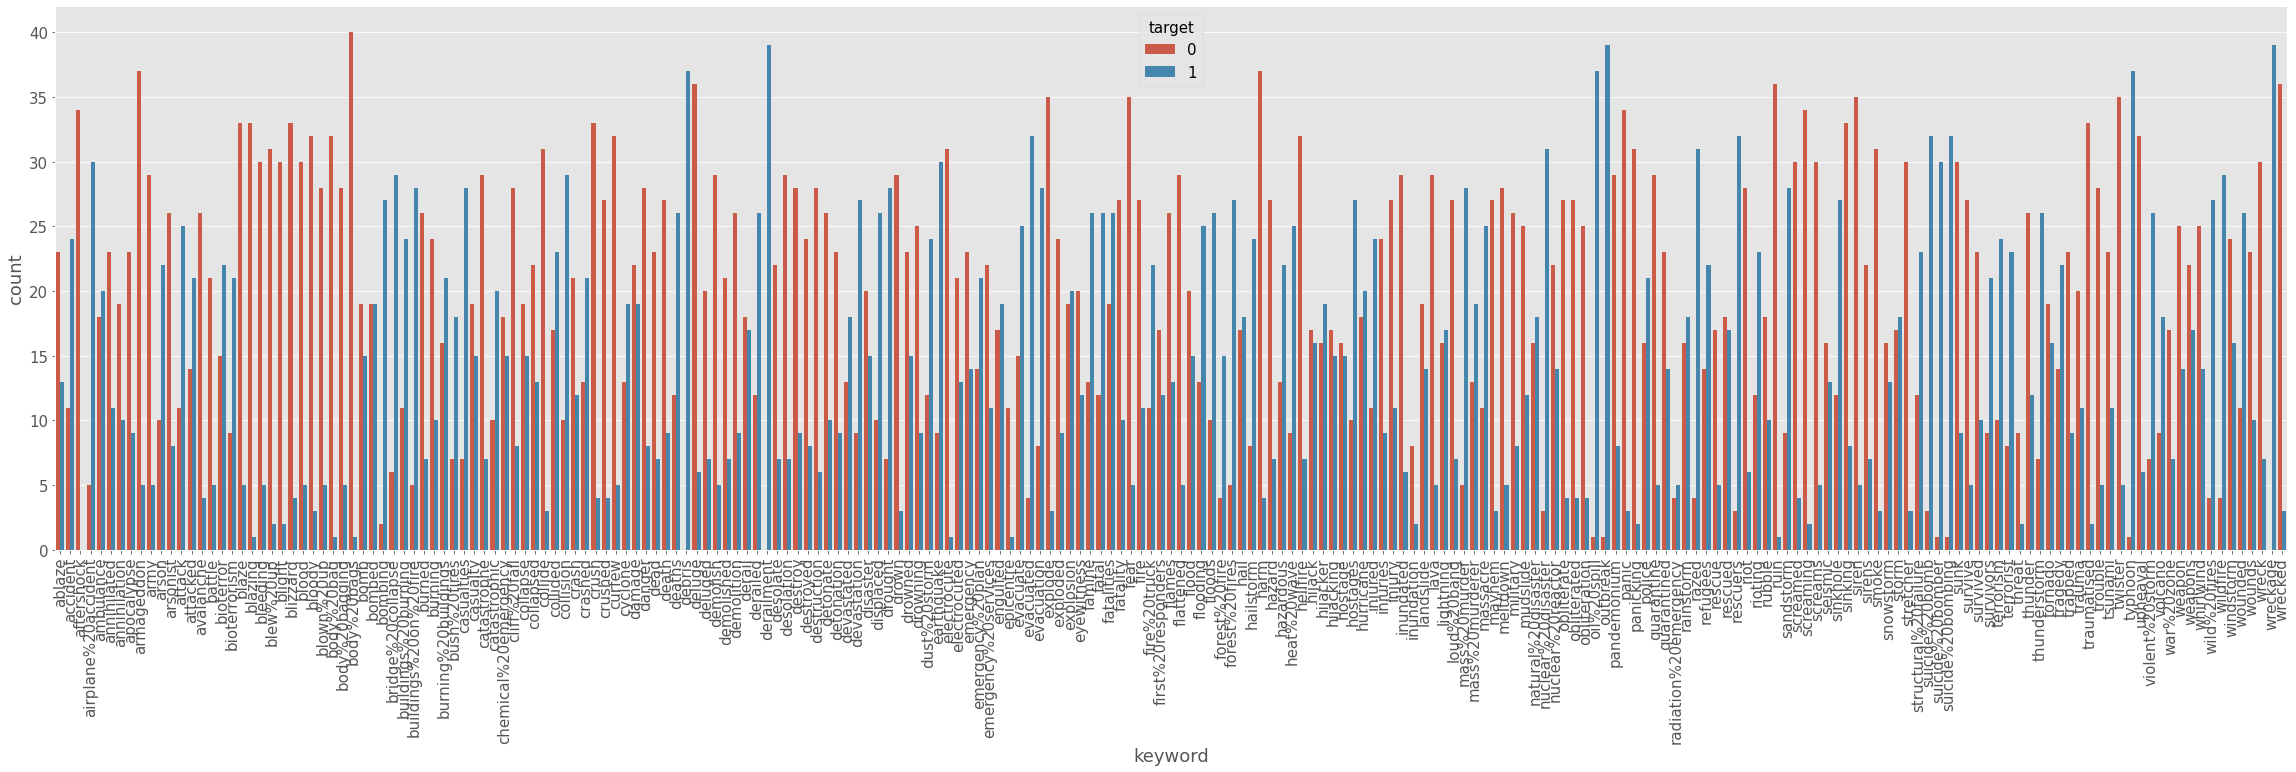

In [11]:
plt.figure(figsize=[40, 10])
sns.countplot(x=KEYWORD, hue=TARGET, data=df_train)
plt.xticks(rotation=90)
plt.show()

Blank spaces indicated by %20. Will require to clean this.

From this chart, it is seen that 'derailment', 'debris' and 'wreckage' are all about real disaster tweets. Body20%bags contains the higest difference between real and non-real disaster tweets where the number of non-real disaster tweets is high. It is actually the highest.

In [12]:
df_train[(df_train[KEYWORD] == 'body%20bags') & (df_train[TARGET] == 1)][TEXT].values

array(['@FoxNews @JenGriffinFNC When you call to report dangerous activity tell em to have body bags on arrival.'],
      dtype=object)

## Target Imabalance

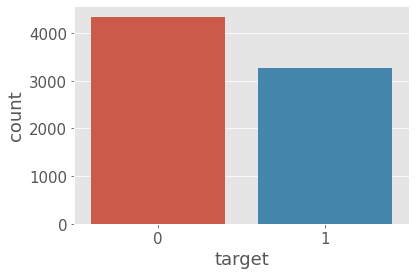

In [13]:
sns.countplot(x=TARGET, data=df_train)
plt.show()

This dataset is imbalanced. The disprity is of ~1000 datapoints where the number of non-disastrous tweets are higher.

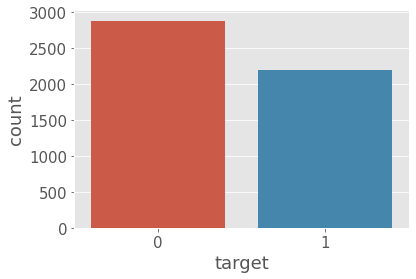

In [14]:
sns.countplot(x=TARGET, data=df_train[~df_train[LOCATION].isna()])
plt.show()

For the tweets whose location is NOT missing, the data imabalance is true in this case as well. Therefore, dropping the location null data will not help balancing the data.

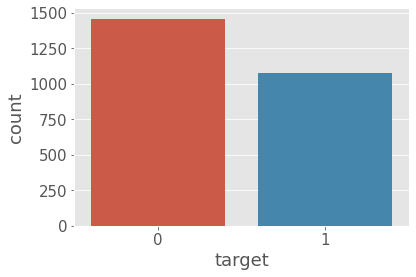

In [15]:
sns.countplot(x=TARGET, data=df_train[df_train[LOCATION].isna()])
plt.show()

For the tweets whose location is missing, the data imabalance is true in this case as well.

## Top 20 locations

In [16]:
df_train[df_train[TARGET] == 1].groupby(LOCATION)[TARGET].count().reset_index()

,location,target
0,,1
1,News,1
2,"616 Û¢ Kentwood , MI",1
3,? ??????? ? ( ?? å¡ ? ? ? å¡),1
4,Alberta,1
...,...,...
1508,"ÌÏT: 40.562796,-75.488849",1
1509,"ÌÏT: 41.252426,-96.072013",1
1510,"ÌÏT: 6.4682,3.18287",1
1511,"ÌÏT: 6.488400524109015,3.352798039832285",1


In [17]:
df_train[df_train[TARGET] == 1].groupby(
    LOCATION)[TARGET].count().reset_index().sort_values(by=TARGET)

,location,target
0,,1
979,Porthcawl,1
978,"Portage, IN / Worldwide",1
977,Port Williams NS,1
976,"Port Orange, FL",1
...,...,...
787,Mumbai,19
576,India,20
857,Nigeria,22
1258,United States,27


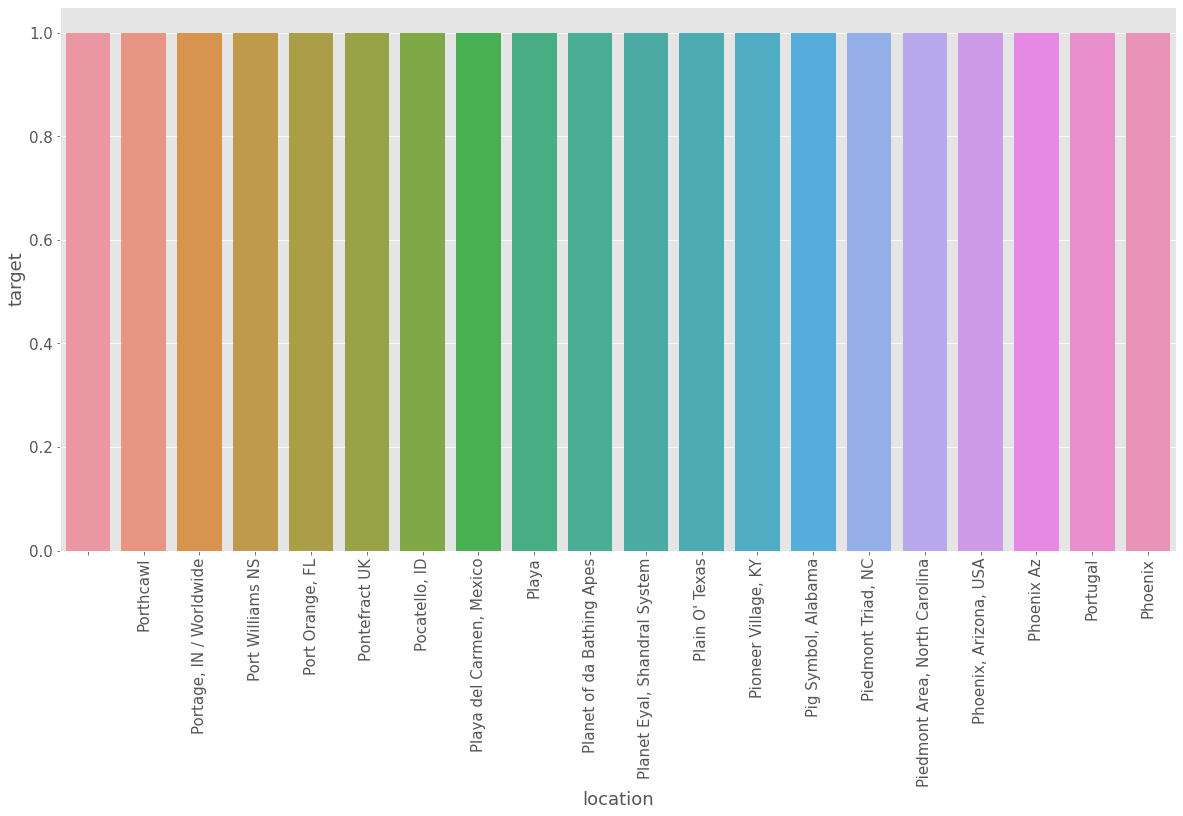

In [18]:
plt.figure(figsize=[20, 10])
sns.barplot(x=LOCATION,
            y=TARGET,
            data=df_train[df_train[TARGET] == 1].groupby(LOCATION)
            [TARGET].count().reset_index().sort_values(by=TARGET)[:20])
plt.xticks(rotation=90)
plt.show()

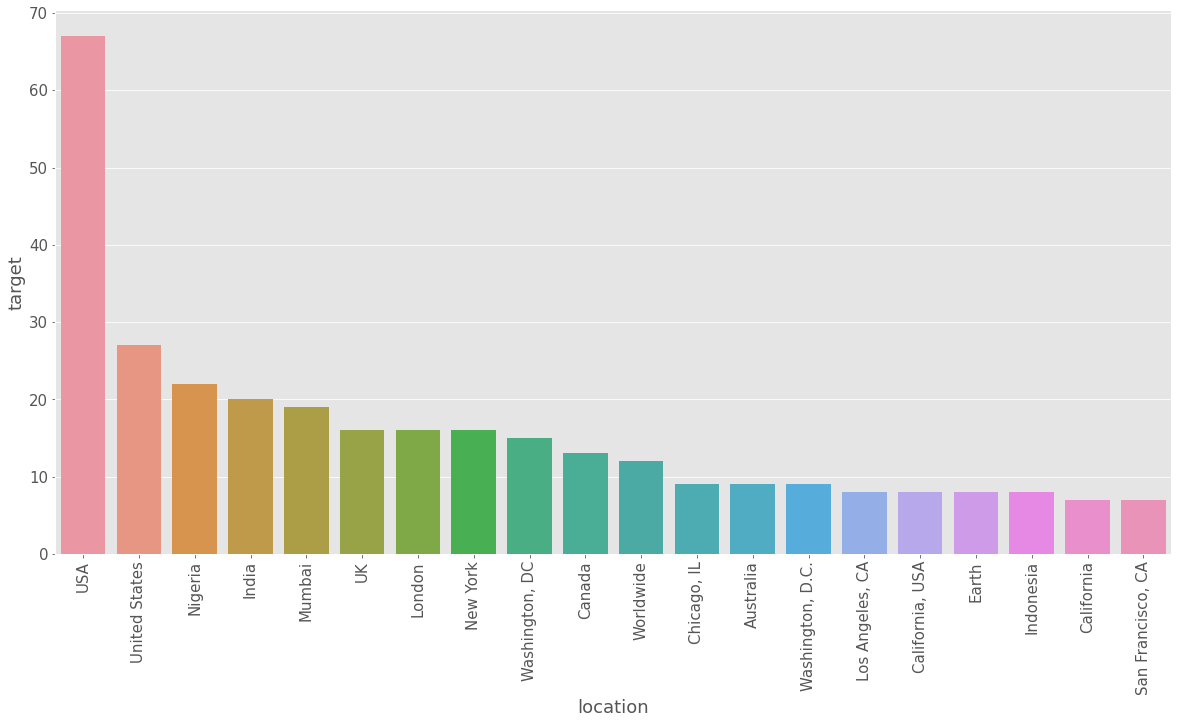

In [19]:
plt.figure(figsize=[20, 10])
sns.barplot(x=LOCATION,
            y=TARGET,
            data=df_train[df_train[TARGET] == 1].groupby(LOCATION)
            [TARGET].count().reset_index().sort_values(by=TARGET,
                                                       ascending=False)[:20])
plt.xticks(rotation=90)
plt.show()

There is an overlap of countries, cities and there are also co-ordinate information plus some gibberish data.

## Text Check

Here is have random tweet text checks  to see what is in there

In [20]:
df_train[TEXT][8], df_train[TARGET][8]

("There's an emergency evacuation happening now in the building across the street",
 1)

In [21]:
df_train[TEXT][20], df_train[TARGET][20]

('this is ridiculous....', 0)

In [22]:
df_train[TEXT][1000] , df_train[TARGET][1000]

('#OVOFest Drake straight body bagging Meek on that OVO stage. #ZIPHIMUP!', 0)

In [23]:
df_train[TEXT][2000] , df_train[TARGET][2000]

('@BradleyBrad47 the saw is fast af and does great damage i upgraded it a shitton and used it exclusively for a whole playthrough',
 0)

## Test Data Check

In [24]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [25]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

**Notes:**

To remove:
1. urls from the texts, 
2. html tags
3. mentions using @.
4. %20 from keywords

Will retain hashtags since importance information lies in hasgtags but will remove the # in them.

# Basic Cleaning

## Cleaning Tests

In [26]:
test_string = 'I am at https://www.nabanita.org www.nabanita.org okay'
url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
test_op = re.sub(url_pattern, '', test_string)
test_op

'I am at   okay'

In [27]:
test_string = 'I am at <p>www.nabanita.org &nbsp;</p>'
html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at www.nabanita.org '

In [28]:
test_string = 'I am at <p>www.nabanita.org'
html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at www.nabanita.org'

In [29]:
test_string = 'I am at @nabanita #python testing 123'
html_entities = r'@([a-z0-9]+)|#'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at  python testing 123'

A tweet might tag news channels as well which contains the word 'news'. If they are twitter handles, then the information will be lost. Hence adding this function to add the keyword news to the tweet if the word is present in the tweet text.

## Implementation

In [30]:
def remove_urls(text):
    ''' This method takes in text to remove urls and website links, if any'''
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)
    return text

def remove_html_entities(text):
    ''' This method removes html tags'''
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    text = re.sub(html_entities, '', text)
    return text

def convert_lower_case(text):
    return text.lower()

def detect_news(text):
    if 'news' in text:
        text = text + ' news'
    return text

def remove_social_media_tags(text):
    ''' This method removes @ and # tags'''
    tag_pattern = r'@([a-z0-9]+)|#'
    text = re.sub(tag_pattern, '', text)
    return text

def remove_stopwords(text):
    text = text.split()
    text = " ".join([word for word in text if not word in STOPWORDS])
    return text

In [31]:
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_urls(x))
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_html_entities(x))
df_train[TEXT] = df_train[TEXT].apply(lambda x : convert_lower_case(x))
df_train[TEXT] = df_train[TEXT].apply(lambda x : detect_news(x))
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_social_media_tags(x))
df_train[TEXT] = df_train[TEXT].apply(lambda x : remove_stopwords(x))

In [32]:
# Test

# Expected to remove @FoxNews but have ' news' in the tweet text

df_train[(df_train[KEYWORD] == 'body%20bags') & (df_train[TARGET] == 1)][TEXT].values

array(['call report dangerous activity tell em body bags arrival. news'],
      dtype=object)

In [33]:
def clean_keyword(text):
    if text is not np.nan and text:
        text = text.replace('%20', ' ')
    return text

In [34]:
df_train[KEYWORD] = df_train[KEYWORD].apply(lambda x : clean_keyword(x))

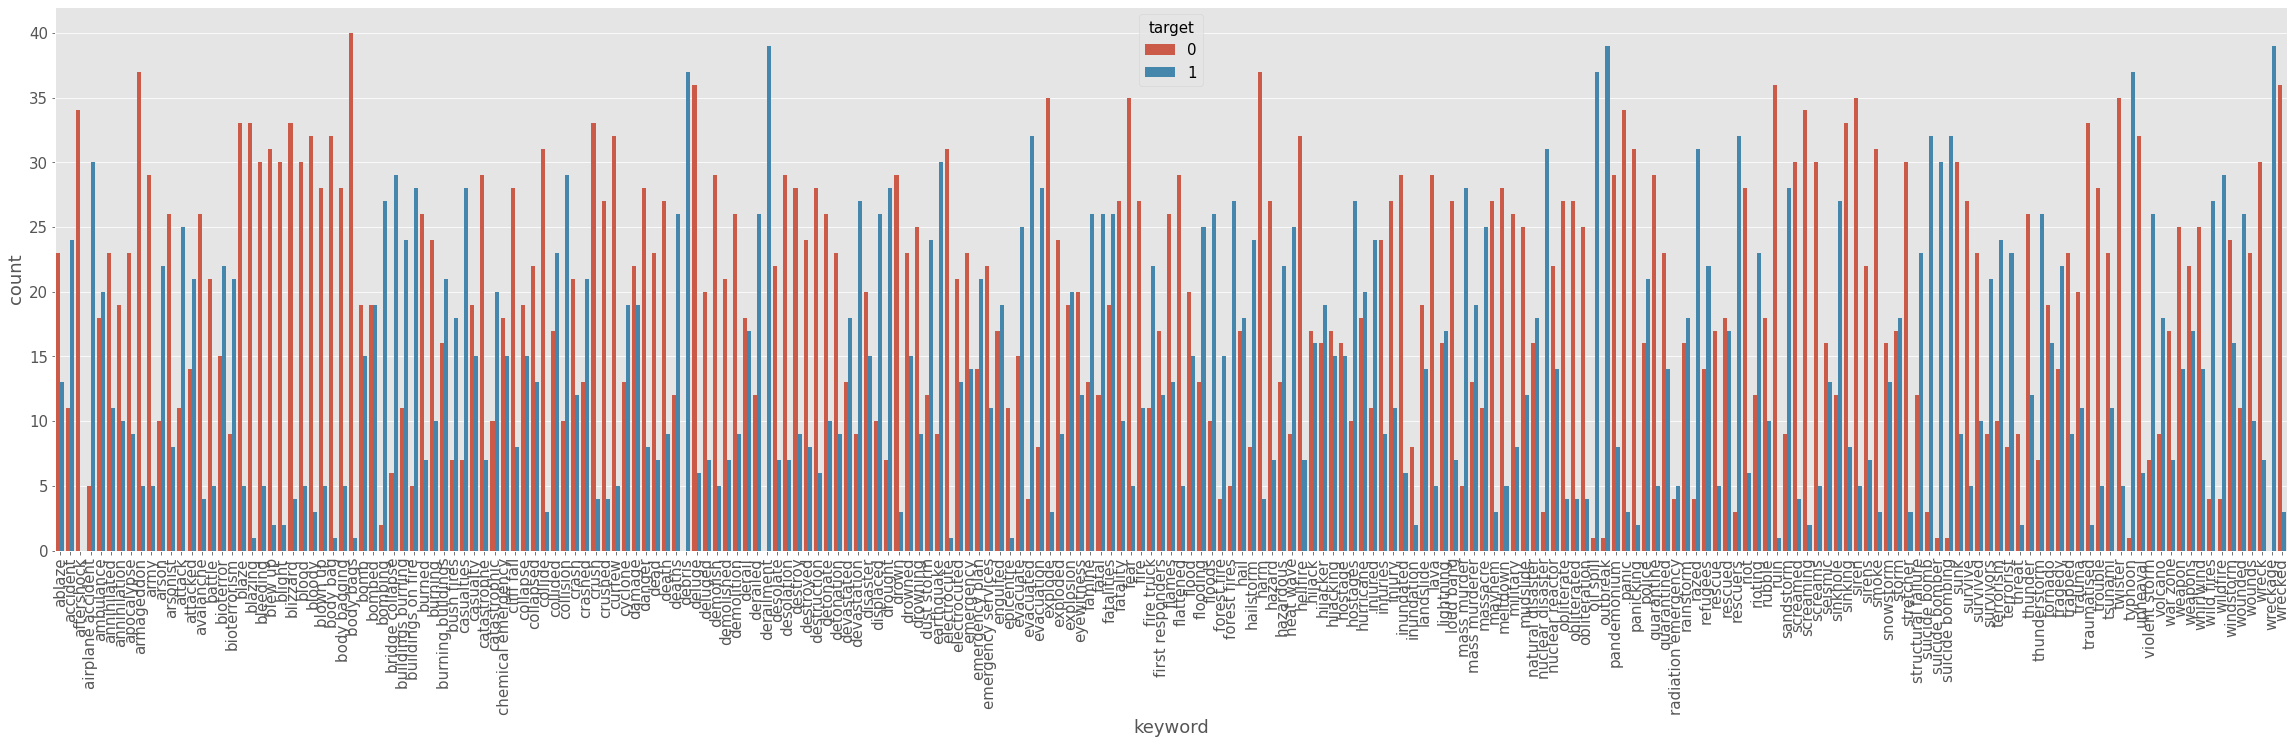

In [35]:
# Testing if %20 is replaced by space

plt.figure(figsize=[40, 10])
sns.countplot(x=KEYWORD, hue=TARGET, data=df_train)
plt.xticks(rotation=90)
plt.show()

# Mention of Numbers in Tweets

In [36]:
def get_numbers_in_tweet(text):
    list_numbers = re.findall(r'\d+', text)
    if list_numbers:
        return 1
    return 0

In [37]:
df_train[NUM_IN_TWEETS] = df_train[TEXT].apply(lambda x: get_numbers_in_tweet(x))

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               7613 non-null   int64 
 1   keyword          7552 non-null   object
 2   location         5080 non-null   object
 3   text             7613 non-null   object
 4   target           7613 non-null   int64 
 5   Number in Tweet  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


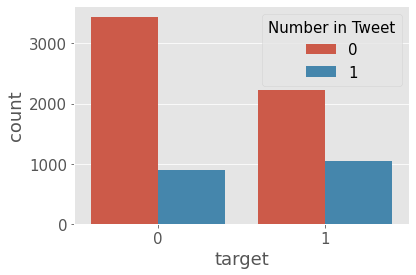

In [39]:
sns.countplot(x=TARGET, hue=NUM_IN_TWEETS, data=df_train)
plt.show()

The probability of having numbers in tweets about real disasters.

# Sentiment Analysis

In [40]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [41]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [42]:
df_train[SENTIMENT] = df_train[TEXT].apply(lambda x: nlp(x)._.polarity)

In [43]:
df_train.head()

,id,keyword,location,text,target,Number in Tweet,Sentiment Score
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,0,0.0
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,0,0.1
2,5,NaN,NaN,residents asked 'shelter place' notified offic...,1,0,-0.1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,1,0.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,0,0.0


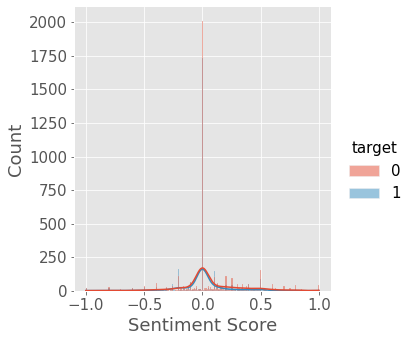

In [44]:
sns.displot(x=SENTIMENT, hue=TARGET, data=df_train, kde=True)
plt.show()

In [45]:
df_train[SENTIMENT_ROUND] = df_train[SENTIMENT].apply(round)
df_train.head()

,id,keyword,location,text,target,Number in Tweet,Sentiment Score,Sentiment Score (rounded off)
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,0,0.0,0
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,0,0.1,0
2,5,NaN,NaN,residents asked 'shelter place' notified offic...,1,0,-0.1,0
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,1,0.0,0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,0,0.0,0


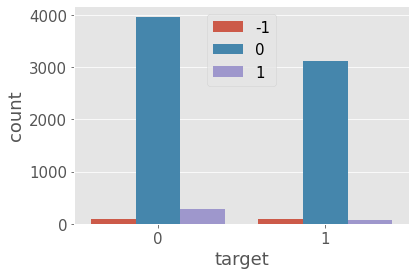

In [46]:
sns.countplot(x=TARGET, hue=SENTIMENT_ROUND, data=df_train)
plt.legend()
plt.show()

Since this data will be used later for modelling, I will use a label encoder in the pipeline to get rid of the negative number.

# Location Analysis

In [47]:
# import time
# from geopy.geocoders import Nominatim

# geolocator = Nominatim(user_agent="my_app")

# def print_location(loc):
#     if loc:
#         try:
#             location = geolocator.geocode(loc)
#             return location
#         except:
#             time.sleep(1)
#             try:
#                 location = geolocator.geocode(loc)
#                 return location
#             except:
#                 print(loc)

# df_train[_LOCATION_] = df_train[LOCATION].apply(lambda x: print_location(x))
# df_train.head()

In [48]:
def check_location(spacy_loc):
    ''' This method checks if the tweet location has any actual location 
    and saves them as as space-separated value if more than one.
    If no location is found, then save blank'''
    num_loc_in_tweet = len([ent.label_ for ent in spacy_loc.ents if ent.label_ == 'GPE'])
    if num_loc_in_tweet:
        locs_in_tweet = [ent.text for ent in spacy_loc.ents if ent.label_ == 'GPE']
    else:
        return nlp(''), 0
    return nlp(' '.join(locs_in_tweet)), 1

df_train[LOCATION].fillna('', inplace=True)
df_train[_LOC_SPACY_OBJ_] = df_train[LOCATION].apply(nlp)
df_train[_LOC_SPACY_OBJ_], df_train[IDENTIFIABLE_LOCATION] = zip(*df_train[_LOC_SPACY_OBJ_].apply(check_location))

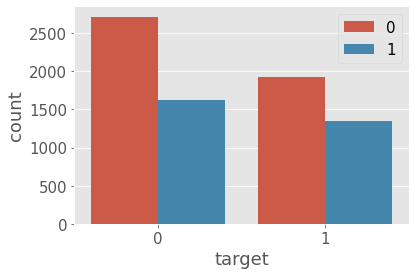

In [49]:
sns.countplot(x=TARGET, hue=IDENTIFIABLE_LOCATION, data=df_train)
plt.legend()
plt.show()

# Tweet Length Analysis

In [51]:
df_train[_TEXT_SPACY_OBJ_] = df_train[TEXT].apply(nlp)

In [52]:
df_train.head()

,id,keyword,location,text,target,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),_LOC_SPACY_OBJ_,Identifiable Location,_TEXT_SPACY_OBJ_
0,1,NaN,,deeds reason earthquake may allah forgive us,1,0,0.0,0,(),0,"(deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,,forest fire near la ronge sask. canada,1,0,0.1,0,(),0,"(forest, fire, near, la, ronge, sask, ., canada)"
2,5,NaN,,residents asked 'shelter place' notified offic...,1,0,-0.1,0,(),0,"(residents, asked, ', shelter, place, ', notif..."
3,6,NaN,,"13,000 people receive wildfires evacuation ord...",1,1,0.0,0,(),0,"(13,000, people, receive, wildfires, evacuatio..."
4,7,NaN,,got sent photo ruby alaska smoke wildfires pou...,1,0,0.0,0,(),0,"(got, sent, photo, ruby, alaska, smoke, wildfi..."


In [53]:
df_train[_WORDS_PER_TWEET_] = df_train[_TEXT_SPACY_OBJ_].apply(len)
df_train[_CHAR_PER_TWEET_] = df_train[TEXT].apply(len)

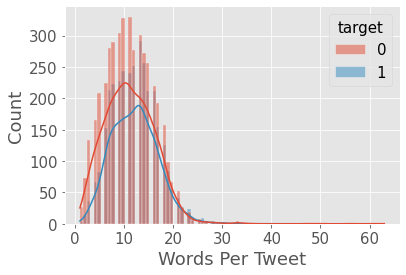

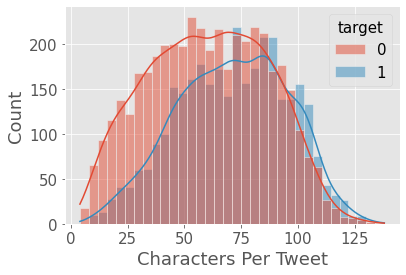

In [54]:
sns.histplot(x=_WORDS_PER_TWEET_, hue=TARGET, data=df_train, kde=True)
plt.show()
sns.histplot(x=_CHAR_PER_TWEET_, hue=TARGET, data=df_train, kde=True)
plt.show()

# Tweet Text Analysis using WordCloud

In [55]:
real_disaster_tweets = ''. join(list(df_train[df_train[TARGET] == 1][TEXT]))

In [56]:
non_real_disaster_tweets = ''. join(list(df_train[df_train[TARGET] == 0][TEXT]))

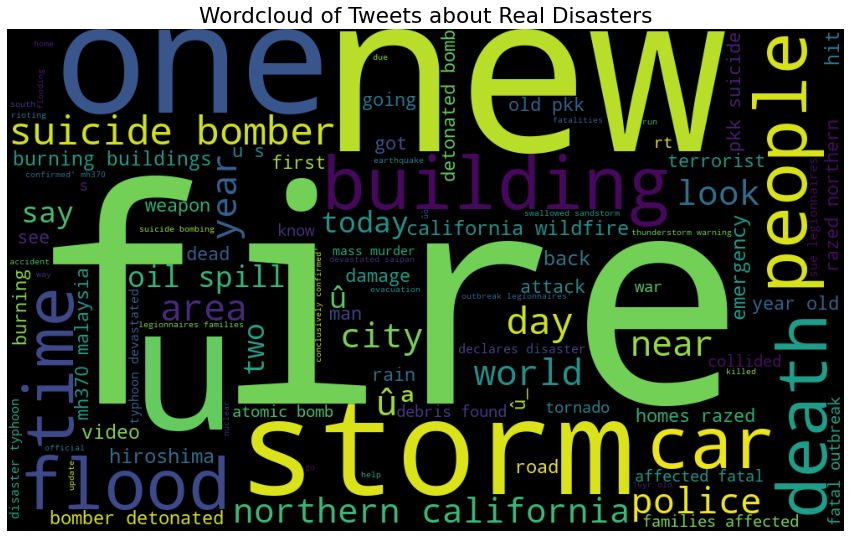

In [57]:
wc = WordCloud(background_color="black", 
               max_words=100, 
               width=1000, 
               height=600, 
               random_state=1).generate(real_disaster_tweets)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Wordcloud of Tweets about Real Disasters")
plt.show()

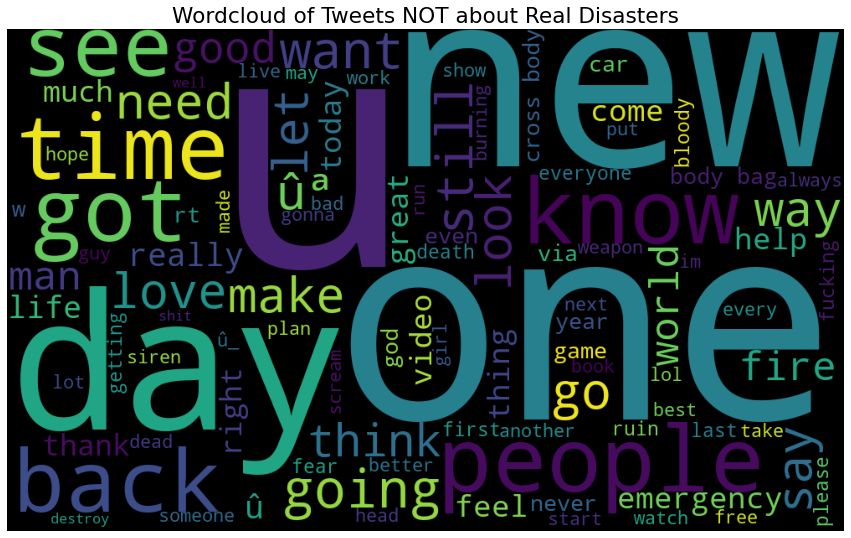

In [58]:
wc = WordCloud(background_color="black", 
               max_words=100, 
               width=1000, 
               height=600,
               font_step=1,
               random_state=1).generate(non_real_disaster_tweets)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Wordcloud of Tweets NOT about Real Disasters")
plt.show()

Emojis are present in the text, as evident on the wordcloud. Therefore, they need to be either detected or removed. I will not be addressing emoji detection in this project.

# Punctiation Analysis

In [59]:
def count_punctuations(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?',text)
    return len(getpunctuation)

In [60]:
df_train[PUNCTUATION_COUNT] = df_train[TEXT].apply(lambda x: count_punctuations(x))

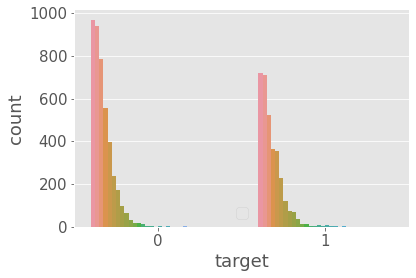

In [61]:
sns.countplot(x=TARGET, hue=PUNCTUATION_COUNT, data=df_train)
plt.legend([])
plt.show()

## Correlation between Tweet Length and Punctuation Count

<AxesSubplot:>

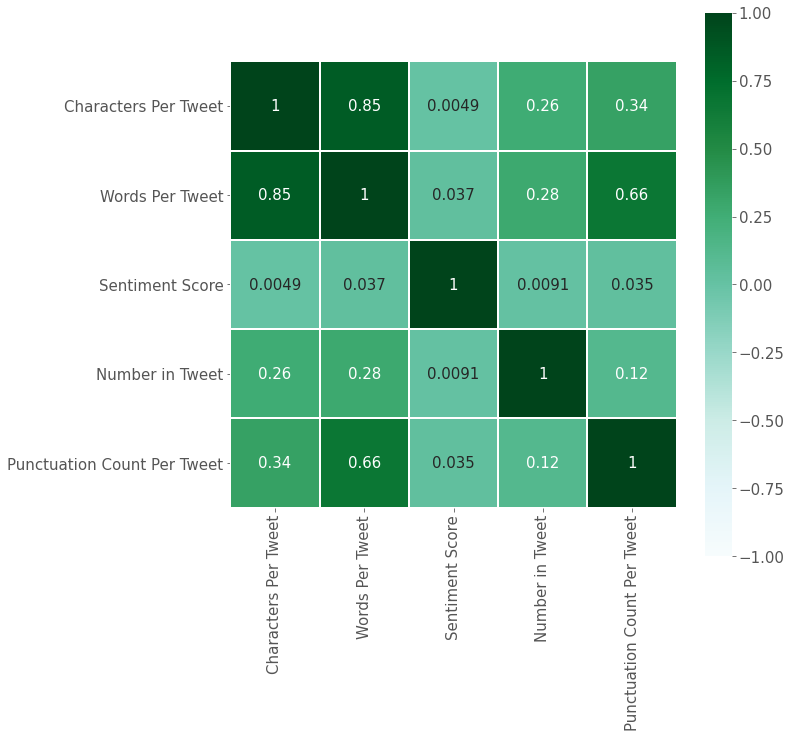

In [62]:
plt.figure(figsize=[10,10])
sns.heatmap(df_train[[_CHAR_PER_TWEET_, _WORDS_PER_TWEET_, SENTIMENT, NUM_IN_TWEETS , PUNCTUATION_COUNT]].corr(),
            annot=True, square=True, vmin=-1, vmax=1, linewidths=1, cmap='BuGn'
           )

# Data Modelling

In [63]:
df_train.head()

,id,keyword,location,text,target,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),_LOC_SPACY_OBJ_,Identifiable Location,_TEXT_SPACY_OBJ_,Words Per Tweet,Characters Per Tweet,Punctuation Count Per Tweet
0,1,NaN,,deeds reason earthquake may allah forgive us,1,0,0.0,0,(),0,"(deeds, reason, earthquake, may, allah, forgiv...",7,44,0
1,4,NaN,,forest fire near la ronge sask. canada,1,0,0.1,0,(),0,"(forest, fire, near, la, ronge, sask, ., canada)",8,38,1
2,5,NaN,,residents asked 'shelter place' notified offic...,1,0,-0.1,0,(),0,"(residents, asked, ', shelter, place, ', notif...",14,91,3
3,6,NaN,,"13,000 people receive wildfires evacuation ord...",1,1,0.0,0,(),0,"(13,000, people, receive, wildfires, evacuatio...",7,60,1
4,7,NaN,,got sent photo ruby alaska smoke wildfires pou...,1,0,0.0,0,(),0,"(got, sent, photo, ruby, alaska, smoke, wildfi...",9,55,0


In [64]:
from spacy.tokens import Doc
df_train[ALL_TEXT] = df_train.apply(lambda x: Doc.from_docs([x[_TEXT_SPACY_OBJ_], x[_LOC_SPACY_OBJ_]]), axis=1)
df_train[ALL_TEXT] = df_train[ALL_TEXT].apply(lambda x: [token.text for token in x])

In [65]:
df_train.head(2)

,id,keyword,location,text,target,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),_LOC_SPACY_OBJ_,Identifiable Location,_TEXT_SPACY_OBJ_,Words Per Tweet,Characters Per Tweet,Punctuation Count Per Tweet,all_text
0,1,NaN,,deeds reason earthquake may allah forgive us,1,0,0.0,0,(),0,"(deeds, reason, earthquake, may, allah, forgiv...",7,44,0,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,,forest fire near la ronge sask. canada,1,0,0.1,0,(),0,"(forest, fire, near, la, ronge, sask, ., canada)",8,38,1,"[forest, fire, near, la, ronge, sask, ., canada]"


In [66]:
df_train[df_train[ID] == 48][ALL_TEXT]

31    [wholesale, markets, ablaze, Birmingham]
Name: all_text, dtype: object

In [67]:
target = df_train[TARGET].values
df_train[ALL_TEXT_JOINED] = df_train[ALL_TEXT].apply(lambda x: " ".join(x))

The training data is ready now. Next step, prepping the test data.

# Test Data Preparation

In [69]:
df_test[TEXT] = df_test[TEXT].apply(lambda x : remove_urls(x))
df_test[TEXT] = df_test[TEXT].apply(lambda x : remove_html_entities(x))
df_test[TEXT] = df_test[TEXT].apply(lambda x : convert_lower_case(x))
df_test[TEXT] = df_test[TEXT].apply(lambda x : detect_news(x))
df_test[TEXT] = df_test[TEXT].apply(lambda x : remove_social_media_tags(x))
df_test[TEXT] = df_test[TEXT].apply(lambda x : convert_lower_case(x))

df_test[KEYWORD] = df_test[KEYWORD].apply(lambda x : clean_keyword(x))

df_test[_TEXT_SPACY_OBJ_] = df_test[TEXT].apply(nlp)

df_test[LOCATION].fillna('', inplace=True)
df_test[_LOC_SPACY_OBJ_] = df_test[LOCATION].apply(nlp)
df_test[_LOC_SPACY_OBJ_], df_test[IDENTIFIABLE_LOCATION] = zip(*df_test[_LOC_SPACY_OBJ_].apply(check_location))

df_test[NUM_IN_TWEETS] = df_test[TEXT].apply(lambda x: get_numbers_in_tweet(x))
df_test[SENTIMENT] = df_test[TEXT].apply(lambda x: nlp(x)._.polarity)
df_test[SENTIMENT_ROUND] = df_test[SENTIMENT].apply(round)
df_test[_WORDS_PER_TWEET_] = df_test[_TEXT_SPACY_OBJ_].apply(len)
df_test[_CHAR_PER_TWEET_] = df_test[TEXT].apply(len)
df_test[PUNCTUATION_COUNT] = df_test[TEXT].apply(lambda x: count_punctuations(x))

df_test[ALL_TEXT] = df_test.apply(lambda x: Doc.from_docs([x[_TEXT_SPACY_OBJ_], x[_LOC_SPACY_OBJ_]]), axis=1)
df_test[ALL_TEXT] = df_test[ALL_TEXT].apply(lambda x: [token.text for token in x])
df_test[ALL_TEXT_JOINED] = df_test[ALL_TEXT].apply(lambda x: " ".join(x))

The test data is ready now.

In [70]:
df_test.head()

,id,keyword,location,text,_TEXT_SPACY_OBJ_,_LOC_SPACY_OBJ_,Identifiable Location,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),Words Per Tweet,Characters Per Tweet,Punctuation Count Per Tweet,all_text,all_text_joined
0,0,NaN,,just happened a terrible car crash,"(just, happened, a, terrible, car, crash)",(),0,0,-1.00,-1,6,34,0,"[just, happened, a, terrible, car, crash]",just happened a terrible car crash
1,2,NaN,,"heard about earthquake is different cities, st...","(heard, about, earthquake, is, different, citi...",(),0,0,0.25,0,11,63,2,"[heard, about, earthquake, is, different, citi...","heard about earthquake is different cities , s..."
2,3,NaN,,"there is a forest fire at spot pond, geese are...","(there, is, a, forest, fire, at, spot, pond, ,...",(),0,0,0.00,0,22,96,2,"[there, is, a, forest, fire, at, spot, pond, ,...","there is a forest fire at spot pond , geese ar..."
3,9,NaN,,apocalypse lighting. spokane wildfires,"(apocalypse, lighting, ., spokane, wildfires)",(),0,0,0.00,0,5,38,1,"[apocalypse, lighting, ., spokane, wildfires]",apocalypse lighting . spokane wildfires
4,11,NaN,,typhoon soudelor kills 28 in china and taiwan,"(typhoon, soudelor, kills, 28, in, china, and,...",(),0,1,0.00,0,8,45,0,"[typhoon, soudelor, kills, 28, in, china, and,...",typhoon soudelor kills 28 in china and taiwan


# Building a Data Modeling Pipeline

## Baseline 

In [71]:
cols_to_train = [ALL_TEXT_JOINED]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train], df_train[TARGET].values, random_state=42)

pipe = Pipeline([('count_vec', CountVectorizer(ngram_range=(1, 2))), ('tf_idf', TfidfTransformer(smooth_idf=False))])
ct = ColumnTransformer([("tf_idf", pipe, ALL_TEXT_JOINED)], 
                       remainder='passthrough' )

ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)
df_test_sparse = ct.transform(df_test[cols_to_train])

In [72]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
baseline_prediction = log_reg.predict(X_test_sparse)

In [73]:
def print_classification_metrics(y_test, y_pred):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('f1-score: ', f1_score(y_test, y_pred))

In [74]:
print_classification_metrics(y_test, baseline_prediction)

Accuracy:  0.8014705882352942
Precision:  0.8403755868544601
Recall:  0.6605166051660517
f1-score:  0.7396694214876034


In [75]:
def predict_challenge_test_data(model, test_data, filename):
    submission_predictions = model.predict(test_data)
    df_submission = pd.read_csv('data/sample_submission.csv')
    df_submission[TARGET] = submission_predictions
    df_submission.to_csv(filename, index=False)

In [76]:
predict_challenge_test_data(log_reg, df_test_sparse, 'baseline_predictions.csv')

## Adding Other Features

In [133]:
cols_to_train = [
    ALL_TEXT_JOINED, SENTIMENT_ROUND, _WORDS_PER_TWEET_, _CHAR_PER_TWEET_,
    NUM_IN_TWEETS, PUNCTUATION_COUNT, IDENTIFIABLE_LOCATION
]

X_train, X_test, y_train, y_test = train_test_split(df_train[cols_to_train],
                                                    df_train[TARGET].values,
                                                    random_state=42)

cols_to_scale = [_WORDS_PER_TWEET_, _CHAR_PER_TWEET_, PUNCTUATION_COUNT]

pipe_text = Pipeline([('count_vec', CountVectorizer()),
                      ('tf_idf', TfidfTransformer(smooth_idf=False))])

ct = ColumnTransformer(
    [("scaler", StandardScaler(), cols_to_scale),
     ('one_hot_encoder', OneHotEncoder(drop='first', sparse=True), [SENTIMENT_ROUND]),
     ("tf_idf", pipe_text, ALL_TEXT_JOINED)],
    remainder='passthrough')

In [134]:
ct.fit(X_train)
X_train_sparse = ct.transform(X_train)
X_test_sparse = ct.transform(X_test)

In [135]:
log_reg = LogisticRegression()
log_reg.fit(X_train_sparse, y_train)
all_cols_prediction = log_reg.predict(X_test_sparse)

In [136]:
print_classification_metrics(y_test, all_cols_prediction)

Accuracy:  0.7962184873949579
Precision:  0.802275960170697
Recall:  0.6937269372693727
f1-score:  0.7440633245382587


## Testing Multiple Machine Learning Models

In [137]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score'
])

In [138]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train_sparse, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test_sparse)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train_sparse, y_train),
        model.score(X_test_sparse, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [139]:
models_list = [LogisticRegression(),
               SVC(),
               KNeighborsClassifier(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               GradientBoostingClassifier()]

In [140]:
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 0.70 s.
Completed LogisticRegression model's performance assessment.
Training SVC model...
Completed SVC model training.
Time elapsed: 11.87 s.
Completed SVC model's performance assessment.
Training KNeighborsClassifier model...
Completed KNeighborsClassifier model training.
Time elapsed: 0.00 s.
Completed KNeighborsClassifier model's performance assessment.
Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 3.27 s.
Completed DecisionTreeClassifier model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 14.17 s.
Completed RandomForestClassifier model's performance assessment.
Training GradientBoostingClassifier model...
Completed GradientBoostingClassifier model training.
Time elapsed: 5.39 s.
Completed GradientBoostingClassifier model's performance assessment.

In [141]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,0.877036,0.796218,0.802276,0.693727,0.744063,0.70
1,SVC,0.851813,0.754727,0.795222,0.573186,0.666190,11.87
2,KNeighborsClassifier,0.782799,0.676471,0.625798,0.602706,0.614035,0.00
3,DecisionTreeClassifier,0.992468,0.727416,0.692913,0.649446,0.670476,3.27
4,RandomForestClassifier,0.992293,0.786765,0.809741,0.654367,0.723810,14.17
5,GradientBoostingClassifier,0.785602,0.750000,0.844581,0.507995,0.634409,5.39


# HyperParameter Tuning for Model Improvement

Random Forest Classifier is one of the competition winners and therefore I am curious if the F1-score could be improved with tuning the hyperparameters.

## Random Forest Classifier

### Attempt 1

In [144]:
max_depth = [5, 8, 15, 25, 30]
min_samples_leaf = [1, 2, 5, 10]
min_samples_split = [2, 5, 10, 15, 100]
n_estimators = [100, 300, 500, 800, 1200]

param_grid = dict(n_estimators=n_estimators,
                  max_depth = max_depth,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf
                 )

model = RandomForestClassifier()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 1/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; f1: (test=0.161) total time=   1.4s
[CV 2/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; f1: (test=0.154) total time=   1.4s
[CV 3/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; f1: (test=0.140) total time=   1.4s
[CV 4/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; f1: (test=0.126) total time=   1.4s
[CV 5/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; f1: (test=0.140) total time=   1.4s
[CV 1/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; f1: (test=0.151) total time=   4.4s
[CV 2/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; f1: (test=0.161) total time=   4.4s
[CV 3/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; f1: 

[CV 3/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=800; f1: (test=0.133) total time=  11.3s
[CV 4/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=800; f1: (test=0.108) total time=  11.3s
[CV 5/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=800; f1: (test=0.178) total time=  11.4s
[CV 1/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; f1: (test=0.126) total time=  16.9s
[CV 2/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; f1: (test=0.143) total time=  16.9s
[CV 3/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; f1: (test=0.126) total time=  17.2s
[CV 4/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; f1: (test=0.126) total time=  16.9s
[CV 5/5] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; f1: (test=0.154) total time=  17.1s
[CV 1/5] END max_de

[CV 5/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=300; f1: (test=0.171) total time=   1.1s
[CV 1/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=500; f1: (test=0.147) total time=   1.9s
[CV 2/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=500; f1: (test=0.143) total time=   2.0s
[CV 3/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=500; f1: (test=0.126) total time=   1.9s
[CV 4/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=500; f1: (test=0.100) total time=   1.9s
[CV 5/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=500; f1: (test=0.147) total time=   1.9s
[CV 1/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=800; f1: (test=0.144) total time=   3.1s
[CV 2/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=800; f1: (test=0.143) total time=   3.2s
[CV 3/5] END max_depth=5, min_sa

[CV 3/5] END max_depth=5, min_samples_leaf=2, min_samples_split=15, n_estimators=100; f1: (test=0.111) total time=   0.3s
[CV 4/5] END max_depth=5, min_samples_leaf=2, min_samples_split=15, n_estimators=100; f1: (test=0.093) total time=   0.3s
[CV 5/5] END max_depth=5, min_samples_leaf=2, min_samples_split=15, n_estimators=100; f1: (test=0.161) total time=   0.3s
[CV 1/5] END max_depth=5, min_samples_leaf=2, min_samples_split=15, n_estimators=300; f1: (test=0.119) total time=   1.2s
[CV 2/5] END max_depth=5, min_samples_leaf=2, min_samples_split=15, n_estimators=300; f1: (test=0.136) total time=   1.1s
[CV 3/5] END max_depth=5, min_samples_leaf=2, min_samples_split=15, n_estimators=300; f1: (test=0.119) total time=   1.1s
[CV 4/5] END max_depth=5, min_samples_leaf=2, min_samples_split=15, n_estimators=300; f1: (test=0.119) total time=   1.2s
[CV 5/5] END max_depth=5, min_samples_leaf=2, min_samples_split=15, n_estimators=300; f1: (test=0.151) total time=   1.2s
[CV 1/5] END max_depth=5

[CV 1/5] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; f1: (test=0.140) total time=   4.8s
[CV 2/5] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; f1: (test=0.140) total time=   4.9s
[CV 3/5] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; f1: (test=0.129) total time=   4.8s
[CV 4/5] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; f1: (test=0.100) total time=   4.7s
[CV 5/5] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=1200; f1: (test=0.164) total time=   4.8s
[CV 1/5] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100; f1: (test=0.140) total time=   0.3s
[CV 2/5] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100; f1: (test=0.097) total time=   0.3s
[CV 3/5] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100; f1: (test=0.154) total time=   0.3s
[CV 4/5] END max_depth=5, m

[CV 4/5] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=500; f1: (test=0.111) total time=   1.9s
[CV 5/5] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=500; f1: (test=0.171) total time=   2.0s
[CV 1/5] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=800; f1: (test=0.119) total time=   3.1s
[CV 2/5] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=800; f1: (test=0.171) total time=   3.2s
[CV 3/5] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=800; f1: (test=0.119) total time=   3.1s
[CV 4/5] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=800; f1: (test=0.115) total time=   3.1s
[CV 5/5] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=800; f1: (test=0.154) total time=   3.1s
[CV 1/5] END max_depth=5, min_samples_leaf=5, min_samples_split=15, n_estimators=1200; f1: (test=0.137) total time=   4.7s
[CV 2/5] END max_depth=

[CV 1/5] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=300; f1: (test=0.119) total time=   1.1s
[CV 2/5] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=300; f1: (test=0.129) total time=   1.1s
[CV 3/5] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=300; f1: (test=0.122) total time=   1.1s
[CV 4/5] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=300; f1: (test=0.086) total time=   1.1s
[CV 5/5] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=300; f1: (test=0.137) total time=   1.2s
[CV 1/5] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; f1: (test=0.122) total time=   2.0s
[CV 2/5] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; f1: (test=0.129) total time=   2.0s
[CV 3/5] END max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=500; f1: (test=0.104) total time=   2.0s
[CV 4/5] END max_depth=5

[CV 3/5] END max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; f1: (test=0.122) total time=   4.7s
[CV 4/5] END max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; f1: (test=0.100) total time=   4.8s
[CV 5/5] END max_depth=5, min_samples_leaf=10, min_samples_split=15, n_estimators=1200; f1: (test=0.126) total time=   4.9s
[CV 1/5] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=100; f1: (test=0.089) total time=   0.3s
[CV 2/5] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=100; f1: (test=0.119) total time=   0.3s
[CV 3/5] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=100; f1: (test=0.104) total time=   0.3s
[CV 4/5] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=100; f1: (test=0.071) total time=   0.3s
[CV 5/5] END max_depth=5, min_samples_leaf=10, min_samples_split=100, n_estimators=100; f1: (test=0.089) total time=   0.3s
[CV 1/5]

[CV 5/5] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=500; f1: (test=0.271) total time=   2.8s
[CV 1/5] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=800; f1: (test=0.234) total time=   4.6s
[CV 2/5] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=800; f1: (test=0.268) total time=   4.6s
[CV 3/5] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=800; f1: (test=0.217) total time=   4.6s
[CV 4/5] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=800; f1: (test=0.224) total time=   4.6s
[CV 5/5] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=800; f1: (test=0.280) total time=   4.7s
[CV 1/5] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; f1: (test=0.227) total time=   7.0s
[CV 2/5] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; f1: (test=0.271) total time=   7.1s
[CV 3/5] END max_depth=8, min_

[CV 3/5] END max_depth=8, min_samples_leaf=1, min_samples_split=100, n_estimators=300; f1: (test=0.224) total time=   1.6s
[CV 4/5] END max_depth=8, min_samples_leaf=1, min_samples_split=100, n_estimators=300; f1: (test=0.224) total time=   1.7s
[CV 5/5] END max_depth=8, min_samples_leaf=1, min_samples_split=100, n_estimators=300; f1: (test=0.268) total time=   1.6s
[CV 1/5] END max_depth=8, min_samples_leaf=1, min_samples_split=100, n_estimators=500; f1: (test=0.240) total time=   2.8s
[CV 2/5] END max_depth=8, min_samples_leaf=1, min_samples_split=100, n_estimators=500; f1: (test=0.252) total time=   2.7s
[CV 3/5] END max_depth=8, min_samples_leaf=1, min_samples_split=100, n_estimators=500; f1: (test=0.198) total time=   2.7s
[CV 4/5] END max_depth=8, min_samples_leaf=1, min_samples_split=100, n_estimators=500; f1: (test=0.214) total time=   2.8s
[CV 5/5] END max_depth=8, min_samples_leaf=1, min_samples_split=100, n_estimators=500; f1: (test=0.268) total time=   2.8s
[CV 1/5] END max

[CV 1/5] END max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=100; f1: (test=0.256) total time=   2.0s
[CV 2/5] END max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=100; f1: (test=0.271) total time=   1.9s
[CV 3/5] END max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=100; f1: (test=0.246) total time=   1.9s
[CV 4/5] END max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=100; f1: (test=0.214) total time=   2.0s
[CV 5/5] END max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=100; f1: (test=0.292) total time=   1.9s
[CV 1/5] END max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=300; f1: (test=0.243) total time=   5.9s
[CV 2/5] END max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=300; f1: (test=0.242) total time=   5.4s
[CV 3/5] END max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=300; f1: (test=0.198) total time=   5.4s
[CV 4/5] END max_depth=8

[CV 3/5] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=800; f1: (test=0.217) total time=  16.1s
[CV 4/5] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=800; f1: (test=0.201) total time=  16.2s
[CV 5/5] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=800; f1: (test=0.271) total time=  16.2s
[CV 1/5] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; f1: (test=0.218) total time=  24.4s
[CV 2/5] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; f1: (test=0.268) total time=  24.2s
[CV 3/5] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; f1: (test=0.211) total time=  24.1s
[CV 4/5] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; f1: (test=0.217) total time=  24.1s
[CV 5/5] END max_depth=8, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; f1: (test=0.283) total time=  23.7s
[CV 1/5] EN

[CV 1/5] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500; f1: (test=0.237) total time=  10.1s
[CV 2/5] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500; f1: (test=0.242) total time=  10.1s
[CV 3/5] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500; f1: (test=0.211) total time=  10.1s
[CV 4/5] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500; f1: (test=0.227) total time=  10.1s
[CV 5/5] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=500; f1: (test=0.280) total time=   9.9s
[CV 1/5] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=800; f1: (test=0.246) total time=  16.1s
[CV 2/5] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=800; f1: (test=0.265) total time=  16.2s
[CV 3/5] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=800; f1: (test=0.221) total time=  16.2s
[CV 4/5] END max_depth=8

[CV 3/5] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=100; f1: (test=0.198) total time=   1.9s
[CV 4/5] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=100; f1: (test=0.204) total time=   1.8s
[CV 5/5] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=100; f1: (test=0.258) total time=   1.9s
[CV 1/5] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=300; f1: (test=0.224) total time=   5.8s
[CV 2/5] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=300; f1: (test=0.221) total time=   5.8s
[CV 3/5] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=300; f1: (test=0.201) total time=   5.8s
[CV 4/5] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=300; f1: (test=0.208) total time=   5.6s
[CV 5/5] END max_depth=8, min_samples_leaf=10, min_samples_split=2, n_estimators=300; f1: (test=0.234) total time=   5.7s
[CV 1/5] END max_depth=8

[CV 5/5] END max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=800; f1: (test=0.246) total time=   4.3s
[CV 1/5] END max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; f1: (test=0.211) total time=   6.6s
[CV 2/5] END max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; f1: (test=0.224) total time=   6.6s
[CV 3/5] END max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; f1: (test=0.194) total time=   6.5s
[CV 4/5] END max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; f1: (test=0.198) total time=   6.7s
[CV 5/5] END max_depth=8, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; f1: (test=0.240) total time=   6.6s
[CV 1/5] END max_depth=8, min_samples_leaf=10, min_samples_split=15, n_estimators=100; f1: (test=0.201) total time=   0.4s
[CV 2/5] END max_depth=8, min_samples_leaf=10, min_samples_split=15, n_estimators=100; f1: (test=0.224) total time=   0.5s
[CV 3/5] EN

[CV 2/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=500; f1: (test=0.408) total time=   5.3s
[CV 3/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=500; f1: (test=0.355) total time=   5.3s
[CV 4/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=500; f1: (test=0.353) total time=   5.2s
[CV 5/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=500; f1: (test=0.427) total time=   5.3s
[CV 1/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=800; f1: (test=0.370) total time=   8.5s
[CV 2/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=800; f1: (test=0.419) total time=   8.4s
[CV 3/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=800; f1: (test=0.360) total time=   8.4s
[CV 4/5] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=800; f1: (test=0.348) total time=   8.4s
[CV 5/5] END max_depth=1

[CV 4/5] END max_depth=15, min_samples_leaf=1, min_samples_split=15, n_estimators=100; f1: (test=0.373) total time=   1.2s
[CV 5/5] END max_depth=15, min_samples_leaf=1, min_samples_split=15, n_estimators=100; f1: (test=0.417) total time=   1.2s
[CV 1/5] END max_depth=15, min_samples_leaf=1, min_samples_split=15, n_estimators=300; f1: (test=0.373) total time=   4.0s
[CV 2/5] END max_depth=15, min_samples_leaf=1, min_samples_split=15, n_estimators=300; f1: (test=0.398) total time=   4.0s
[CV 3/5] END max_depth=15, min_samples_leaf=1, min_samples_split=15, n_estimators=300; f1: (test=0.352) total time=   3.9s
[CV 4/5] END max_depth=15, min_samples_leaf=1, min_samples_split=15, n_estimators=300; f1: (test=0.338) total time=   4.0s
[CV 5/5] END max_depth=15, min_samples_leaf=1, min_samples_split=15, n_estimators=300; f1: (test=0.426) total time=   3.9s
[CV 1/5] END max_depth=15, min_samples_leaf=1, min_samples_split=15, n_estimators=500; f1: (test=0.372) total time=   6.8s
[CV 2/5] END max

[CV 1/5] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; f1: (test=0.374) total time=  11.5s
[CV 2/5] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; f1: (test=0.405) total time=  11.4s
[CV 3/5] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; f1: (test=0.347) total time=  11.5s
[CV 4/5] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; f1: (test=0.364) total time=  11.4s
[CV 5/5] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; f1: (test=0.412) total time=  11.4s
[CV 1/5] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100; f1: (test=0.390) total time=   0.8s
[CV 2/5] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100; f1: (test=0.390) total time=   0.8s
[CV 3/5] END max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100; f1: (test=0.321) total time=   0.8s
[CV 4/5] END max_de

[CV 3/5] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=500; f1: (test=0.339) total time=   4.6s
[CV 4/5] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=500; f1: (test=0.348) total time=   4.7s
[CV 5/5] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=500; f1: (test=0.421) total time=   4.8s
[CV 1/5] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=800; f1: (test=0.371) total time=   7.7s
[CV 2/5] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=800; f1: (test=0.388) total time=   7.7s
[CV 3/5] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=800; f1: (test=0.331) total time=   7.4s
[CV 4/5] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=800; f1: (test=0.348) total time=   7.5s
[CV 5/5] END max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=800; f1: (test=0.423) total time=   7.4s
[CV 1/5] END max

[CV 5/5] END max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=100; f1: (test=0.390) total time=   0.8s
[CV 1/5] END max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=300; f1: (test=0.376) total time=   2.8s
[CV 2/5] END max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=300; f1: (test=0.390) total time=   2.7s
[CV 3/5] END max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=300; f1: (test=0.339) total time=   2.7s
[CV 4/5] END max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=300; f1: (test=0.346) total time=   2.8s
[CV 5/5] END max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=300; f1: (test=0.428) total time=   2.8s
[CV 1/5] END max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=500; f1: (test=0.357) total time=   4.8s
[CV 2/5] END max_depth=15, min_samples_leaf=5, min_samples_split=5, n_estimators=500; f1: (test=0.377) total time=   4.4s
[CV 3/5] END max_depth=1

[CV 2/5] END max_depth=15, min_samples_leaf=5, min_samples_split=15, n_estimators=1200; f1: (test=0.392) total time=  11.0s
[CV 3/5] END max_depth=15, min_samples_leaf=5, min_samples_split=15, n_estimators=1200; f1: (test=0.336) total time=  11.4s
[CV 4/5] END max_depth=15, min_samples_leaf=5, min_samples_split=15, n_estimators=1200; f1: (test=0.348) total time=  11.4s
[CV 5/5] END max_depth=15, min_samples_leaf=5, min_samples_split=15, n_estimators=1200; f1: (test=0.413) total time=  11.4s
[CV 1/5] END max_depth=15, min_samples_leaf=5, min_samples_split=100, n_estimators=100; f1: (test=0.372) total time=   0.9s
[CV 2/5] END max_depth=15, min_samples_leaf=5, min_samples_split=100, n_estimators=100; f1: (test=0.413) total time=   0.8s
[CV 3/5] END max_depth=15, min_samples_leaf=5, min_samples_split=100, n_estimators=100; f1: (test=0.324) total time=   0.9s
[CV 4/5] END max_depth=15, min_samples_leaf=5, min_samples_split=100, n_estimators=100; f1: (test=0.366) total time=   0.8s
[CV 5/5]

[CV 4/5] END max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=500; f1: (test=0.325) total time=   4.4s
[CV 5/5] END max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=500; f1: (test=0.387) total time=   4.4s
[CV 1/5] END max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=800; f1: (test=0.338) total time=   7.1s
[CV 2/5] END max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=800; f1: (test=0.355) total time=   7.1s
[CV 3/5] END max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=800; f1: (test=0.325) total time=   6.9s
[CV 4/5] END max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=800; f1: (test=0.324) total time=   6.9s
[CV 5/5] END max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=800; f1: (test=0.395) total time=   6.9s
[CV 1/5] END max_depth=15, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; f1: (test=0.359) total time=  10.4s
[CV 2/5] END ma

[CV 1/5] END max_depth=15, min_samples_leaf=10, min_samples_split=100, n_estimators=300; f1: (test=0.348) total time=   2.5s
[CV 2/5] END max_depth=15, min_samples_leaf=10, min_samples_split=100, n_estimators=300; f1: (test=0.382) total time=   2.5s
[CV 3/5] END max_depth=15, min_samples_leaf=10, min_samples_split=100, n_estimators=300; f1: (test=0.316) total time=   2.6s
[CV 4/5] END max_depth=15, min_samples_leaf=10, min_samples_split=100, n_estimators=300; f1: (test=0.308) total time=   2.6s
[CV 5/5] END max_depth=15, min_samples_leaf=10, min_samples_split=100, n_estimators=300; f1: (test=0.400) total time=   2.6s
[CV 1/5] END max_depth=15, min_samples_leaf=10, min_samples_split=100, n_estimators=500; f1: (test=0.354) total time=   4.5s
[CV 2/5] END max_depth=15, min_samples_leaf=10, min_samples_split=100, n_estimators=500; f1: (test=0.377) total time=   4.4s
[CV 3/5] END max_depth=15, min_samples_leaf=10, min_samples_split=100, n_estimators=500; f1: (test=0.317) total time=   4.5s


[CV 3/5] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; f1: (test=0.480) total time=  19.8s
[CV 4/5] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; f1: (test=0.459) total time=  19.4s
[CV 5/5] END max_depth=25, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; f1: (test=0.548) total time=  19.5s
[CV 1/5] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=100; f1: (test=0.492) total time=   1.5s
[CV 2/5] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=100; f1: (test=0.541) total time=   1.5s
[CV 3/5] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=100; f1: (test=0.480) total time=   1.5s
[CV 4/5] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=100; f1: (test=0.459) total time=   1.5s
[CV 5/5] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=100; f1: (test=0.527) total time=   1.5s
[CV 1/5] END max

[CV 5/5] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=500; f1: (test=0.540) total time=   7.3s
[CV 1/5] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=800; f1: (test=0.478) total time=  11.6s
[CV 2/5] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=800; f1: (test=0.515) total time=  11.6s
[CV 3/5] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=800; f1: (test=0.471) total time=  11.8s
[CV 4/5] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=800; f1: (test=0.449) total time=  11.8s
[CV 5/5] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=800; f1: (test=0.528) total time=  11.5s
[CV 1/5] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=1200; f1: (test=0.486) total time=  17.4s
[CV 2/5] END max_depth=25, min_samples_leaf=1, min_samples_split=100, n_estimators=1200; f1: (test=0.529) total time=  17.4s
[CV 3/

[CV 2/5] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=300; f1: (test=0.507) total time=   4.2s
[CV 3/5] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=300; f1: (test=0.471) total time=   4.3s
[CV 4/5] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=300; f1: (test=0.459) total time=   4.2s
[CV 5/5] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=300; f1: (test=0.533) total time=   4.2s
[CV 1/5] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=500; f1: (test=0.476) total time=   7.2s
[CV 2/5] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=500; f1: (test=0.510) total time=   7.2s
[CV 3/5] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=500; f1: (test=0.462) total time=   7.3s
[CV 4/5] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=500; f1: (test=0.451) total time=   7.1s
[CV 5/5] END max

[CV 4/5] END max_depth=25, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; f1: (test=0.439) total time=  17.5s
[CV 5/5] END max_depth=25, min_samples_leaf=2, min_samples_split=100, n_estimators=1200; f1: (test=0.541) total time=  17.0s
[CV 1/5] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=100; f1: (test=0.470) total time=   1.3s
[CV 2/5] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=100; f1: (test=0.511) total time=   1.3s
[CV 3/5] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=100; f1: (test=0.452) total time=   1.3s
[CV 4/5] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=100; f1: (test=0.444) total time=   1.3s
[CV 5/5] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=100; f1: (test=0.539) total time=   1.3s
[CV 1/5] END max_depth=25, min_samples_leaf=5, min_samples_split=2, n_estimators=300; f1: (test=0.476) total time=   4.1s
[CV 2/5] END max_d

[CV 1/5] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=800; f1: (test=0.475) total time=  11.0s
[CV 2/5] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=800; f1: (test=0.529) total time=  11.1s
[CV 3/5] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=800; f1: (test=0.460) total time=  11.1s
[CV 4/5] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=800; f1: (test=0.440) total time=  11.1s
[CV 5/5] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=800; f1: (test=0.527) total time=  11.5s
[CV 1/5] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=1200; f1: (test=0.481) total time=  16.7s
[CV 2/5] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=1200; f1: (test=0.521) total time=  16.9s
[CV 3/5] END max_depth=25, min_samples_leaf=5, min_samples_split=10, n_estimators=1200; f1: (test=0.462) total time=  16.8s
[CV 4/5] END 

[CV 3/5] END max_depth=25, min_samples_leaf=10, min_samples_split=2, n_estimators=300; f1: (test=0.433) total time=   3.8s
[CV 4/5] END max_depth=25, min_samples_leaf=10, min_samples_split=2, n_estimators=300; f1: (test=0.428) total time=   3.7s
[CV 5/5] END max_depth=25, min_samples_leaf=10, min_samples_split=2, n_estimators=300; f1: (test=0.465) total time=   3.7s
[CV 1/5] END max_depth=25, min_samples_leaf=10, min_samples_split=2, n_estimators=500; f1: (test=0.431) total time=   6.2s
[CV 2/5] END max_depth=25, min_samples_leaf=10, min_samples_split=2, n_estimators=500; f1: (test=0.461) total time=   6.1s
[CV 3/5] END max_depth=25, min_samples_leaf=10, min_samples_split=2, n_estimators=500; f1: (test=0.434) total time=   6.0s
[CV 4/5] END max_depth=25, min_samples_leaf=10, min_samples_split=2, n_estimators=500; f1: (test=0.423) total time=   6.1s
[CV 5/5] END max_depth=25, min_samples_leaf=10, min_samples_split=2, n_estimators=500; f1: (test=0.487) total time=   6.2s
[CV 1/5] END max

[CV 5/5] END max_depth=25, min_samples_leaf=10, min_samples_split=10, n_estimators=1200; f1: (test=0.476) total time=  15.0s
[CV 1/5] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=100; f1: (test=0.437) total time=   1.1s
[CV 2/5] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=100; f1: (test=0.479) total time=   1.2s
[CV 3/5] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=100; f1: (test=0.399) total time=   1.1s
[CV 4/5] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=100; f1: (test=0.425) total time=   1.2s
[CV 5/5] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=100; f1: (test=0.499) total time=   1.1s
[CV 1/5] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=300; f1: (test=0.433) total time=   3.8s
[CV 2/5] END max_depth=25, min_samples_leaf=10, min_samples_split=15, n_estimators=300; f1: (test=0.488) total time=   3.7s
[CV 3/5

[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=800; f1: (test=0.572) total time=  15.7s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=800; f1: (test=0.519) total time=  16.2s
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=800; f1: (test=0.496) total time=  15.7s
[CV 5/5] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=800; f1: (test=0.578) total time=  15.8s
[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; f1: (test=0.515) total time=  23.9s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; f1: (test=0.569) total time=  23.5s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; f1: (test=0.514) total time=  23.3s
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; f1: (test=0.499) total time=  23.7s
[CV 5/5] END max_dep

[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=15, n_estimators=300; f1: (test=0.495) total time=   5.5s
[CV 5/5] END max_depth=30, min_samples_leaf=1, min_samples_split=15, n_estimators=300; f1: (test=0.573) total time=   5.4s
[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=15, n_estimators=500; f1: (test=0.515) total time=   9.0s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=15, n_estimators=500; f1: (test=0.571) total time=   8.9s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=15, n_estimators=500; f1: (test=0.520) total time=   8.9s
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=15, n_estimators=500; f1: (test=0.499) total time=   8.8s
[CV 5/5] END max_depth=30, min_samples_leaf=1, min_samples_split=15, n_estimators=500; f1: (test=0.567) total time=   9.1s
[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=15, n_estimators=800; f1: (test=0.511) total time=  14.4s
[CV 2/5] END max

[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100; f1: (test=0.519) total time=   1.6s
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100; f1: (test=0.562) total time=   1.6s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100; f1: (test=0.511) total time=   1.6s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100; f1: (test=0.487) total time=   1.6s
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100; f1: (test=0.543) total time=   1.6s
[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300; f1: (test=0.498) total time=   5.0s
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300; f1: (test=0.561) total time=   4.9s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300; f1: (test=0.508) total time=   5.0s
[CV 4/5] END max_depth=3

[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=800; f1: (test=0.500) total time=  13.1s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=800; f1: (test=0.485) total time=  13.1s
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=800; f1: (test=0.572) total time=  13.2s
[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; f1: (test=0.503) total time=  19.8s
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; f1: (test=0.555) total time=  19.7s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; f1: (test=0.498) total time=  19.8s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; f1: (test=0.484) total time=  20.0s
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=1200; f1: (test=0.564) total time=  20.0s
[CV 1/5] EN

[CV 5/5] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=300; f1: (test=0.570) total time=   4.8s
[CV 1/5] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=500; f1: (test=0.503) total time=   8.2s
[CV 2/5] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=500; f1: (test=0.567) total time=   8.1s
[CV 3/5] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=500; f1: (test=0.516) total time=   8.1s
[CV 4/5] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=500; f1: (test=0.480) total time=   7.9s
[CV 5/5] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=500; f1: (test=0.574) total time=   8.0s
[CV 1/5] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=800; f1: (test=0.497) total time=  12.7s
[CV 2/5] END max_depth=30, min_samples_leaf=5, min_samples_split=5, n_estimators=800; f1: (test=0.561) total time=  12.8s
[CV 3/5] END max_depth=3

[CV 2/5] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=100; f1: (test=0.553) total time=   1.5s
[CV 3/5] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=100; f1: (test=0.502) total time=   1.4s
[CV 4/5] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=100; f1: (test=0.473) total time=   1.5s
[CV 5/5] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=100; f1: (test=0.557) total time=   1.5s
[CV 1/5] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=300; f1: (test=0.515) total time=   4.7s
[CV 2/5] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=300; f1: (test=0.564) total time=   4.6s
[CV 3/5] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=300; f1: (test=0.504) total time=   4.6s
[CV 4/5] END max_depth=30, min_samples_leaf=5, min_samples_split=100, n_estimators=300; f1: (test=0.481) total time=   4.6s
[CV 5/5]

[CV 4/5] END max_depth=30, min_samples_leaf=10, min_samples_split=5, n_estimators=800; f1: (test=0.442) total time=  11.4s
[CV 5/5] END max_depth=30, min_samples_leaf=10, min_samples_split=5, n_estimators=800; f1: (test=0.504) total time=  11.0s
[CV 1/5] END max_depth=30, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; f1: (test=0.466) total time=  16.2s
[CV 2/5] END max_depth=30, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; f1: (test=0.509) total time=  16.9s
[CV 3/5] END max_depth=30, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; f1: (test=0.470) total time=  17.3s
[CV 4/5] END max_depth=30, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; f1: (test=0.444) total time=  17.3s
[CV 5/5] END max_depth=30, min_samples_leaf=10, min_samples_split=5, n_estimators=1200; f1: (test=0.510) total time=  16.7s
[CV 1/5] END max_depth=30, min_samples_leaf=10, min_samples_split=10, n_estimators=100; f1: (test=0.487) total time=   1.3s
[CV 2/5] E

[CV 5/5] END max_depth=30, min_samples_leaf=10, min_samples_split=100, n_estimators=300; f1: (test=0.515) total time=   4.0s
[CV 1/5] END max_depth=30, min_samples_leaf=10, min_samples_split=100, n_estimators=500; f1: (test=0.459) total time=   6.7s
[CV 2/5] END max_depth=30, min_samples_leaf=10, min_samples_split=100, n_estimators=500; f1: (test=0.507) total time=   6.9s
[CV 3/5] END max_depth=30, min_samples_leaf=10, min_samples_split=100, n_estimators=500; f1: (test=0.476) total time=   6.8s
[CV 4/5] END max_depth=30, min_samples_leaf=10, min_samples_split=100, n_estimators=500; f1: (test=0.449) total time=   6.8s
[CV 5/5] END max_depth=30, min_samples_leaf=10, min_samples_split=100, n_estimators=500; f1: (test=0.518) total time=   6.6s
[CV 1/5] END max_depth=30, min_samples_leaf=10, min_samples_split=100, n_estimators=800; f1: (test=0.459) total time=  10.9s
[CV 2/5] END max_depth=30, min_samples_leaf=10, min_samples_split=100, n_estimators=800; f1: (test=0.506) total time=  11.2s


In [145]:
model_1 = grid_result.best_estimator_
y_pred_attempt_1 = model_1.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_1)
grid_result.best_params_

Accuracy:  0.7321428571428571
Precision:  0.9522388059701492
Recall:  0.3923739237392374
f1-score:  0.5557491289198606


{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 500}

The results are poorer than the default configurations. 

So now, I will try with a set that narrows down to the best params here and also the boundaries of the lists which are the best params are expanded in the new grid.

### Attempt 2

In [162]:
max_depth = [30, 50, 70 , 90]
min_samples_leaf = [1, 2]
min_samples_split = [10, 20, 30, 40]
n_estimators = [400, 500, 600]

param_grid = dict(max_depth=max_depth,
    n_estimators=n_estimators,min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf
                 )

model = RandomForestClassifier()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   7.8s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   7.7s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   8.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   7.9s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   8.1s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  10.0s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  10.3s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=   9.8s
[CV] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  10.1s
[CV] END max_depth=3

[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   8.1s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   8.2s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   8.2s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   8.6s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=   8.5s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=20, n_estimators=600; total time=   9.9s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=20, n_estimators=600; total time=  10.2s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=20, n_estimators=600; total time=   9.8s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=20, n_estimators=600; total time=   9.8s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=20, n_estimators=600;

[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=30, n_estimators=600; total time=  35.9s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=30, n_estimators=600; total time=  38.5s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=30, n_estimators=600; total time=  37.7s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=30, n_estimators=600; total time=  34.1s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=  24.5s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=  23.7s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=  21.9s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=  28.3s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=  23.3s
[CV] END max_depth=50, min_samples_leaf=1, min_samples_split=40, n_estimators=500;

[CV] END max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  37.9s
[CV] END max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  36.9s
[CV] END max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  36.5s
[CV] END max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  47.3s
[CV] END max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  46.5s
[CV] END max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  49.6s
[CV] END max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  47.7s
[CV] END max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time=  43.1s
[CV] END max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=  51.4s
[CV] END max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=600;

[CV] END max_depth=70, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=  15.7s
[CV] END max_depth=70, min_samples_leaf=2, min_samples_split=20, n_estimators=500; total time=  15.7s
[CV] END max_depth=70, min_samples_leaf=2, min_samples_split=20, n_estimators=600; total time=  20.1s
[CV] END max_depth=70, min_samples_leaf=2, min_samples_split=20, n_estimators=600; total time=  24.6s
[CV] END max_depth=70, min_samples_leaf=2, min_samples_split=20, n_estimators=600; total time=  23.1s
[CV] END max_depth=70, min_samples_leaf=2, min_samples_split=20, n_estimators=600; total time=  22.7s
[CV] END max_depth=70, min_samples_leaf=2, min_samples_split=20, n_estimators=600; total time=  23.7s
[CV] END max_depth=70, min_samples_leaf=2, min_samples_split=30, n_estimators=400; total time=  13.1s
[CV] END max_depth=70, min_samples_leaf=2, min_samples_split=30, n_estimators=400; total time=  13.0s
[CV] END max_depth=70, min_samples_leaf=2, min_samples_split=30, n_estimators=400;

[CV] END max_depth=90, min_samples_leaf=1, min_samples_split=30, n_estimators=600; total time=  24.4s
[CV] END max_depth=90, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=  16.1s
[CV] END max_depth=90, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=  15.7s
[CV] END max_depth=90, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=  15.7s
[CV] END max_depth=90, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=  15.8s
[CV] END max_depth=90, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=  15.8s
[CV] END max_depth=90, min_samples_leaf=1, min_samples_split=40, n_estimators=500; total time=  19.8s
[CV] END max_depth=90, min_samples_leaf=1, min_samples_split=40, n_estimators=500; total time=  19.9s
[CV] END max_depth=90, min_samples_leaf=1, min_samples_split=40, n_estimators=500; total time=  20.2s
[CV] END max_depth=90, min_samples_leaf=1, min_samples_split=40, n_estimators=500;

In [163]:
model_2 = grid_result.best_estimator_
y_pred_attempt_2 = model_1.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_2)
grid_result.best_params_

Accuracy:  0.7321428571428571
Precision:  0.9522388059701492
Recall:  0.3923739237392374
f1-score:  0.5557491289198606


{'max_depth': 90,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'n_estimators': 600}

### Attempt 3

In [164]:
min_samples_leaf = [1, 2]
min_samples_split = [30]
n_estimators = [500]

param_grid = dict(n_estimators=n_estimators,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf
                 )

model = RandomForestClassifier()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END min_samples_leaf=1, min_samples_split=30, n_estimators=500; f1: (test=0.680) total time=  36.4s
[CV 2/5] END min_samples_leaf=1, min_samples_split=30, n_estimators=500; f1: (test=0.708) total time=  37.5s
[CV 3/5] END min_samples_leaf=1, min_samples_split=30, n_estimators=500; f1: (test=0.703) total time=  36.3s
[CV 4/5] END min_samples_leaf=1, min_samples_split=30, n_estimators=500; f1: (test=0.674) total time=  37.0s
[CV 5/5] END min_samples_leaf=1, min_samples_split=30, n_estimators=500; f1: (test=0.692) total time=  36.2s
[CV 1/5] END min_samples_leaf=2, min_samples_split=30, n_estimators=500; f1: (test=0.684) total time=  28.2s
[CV 2/5] END min_samples_leaf=2, min_samples_split=30, n_estimators=500; f1: (test=0.722) total time=  28.2s
[CV 3/5] END min_samples_leaf=2, min_samples_split=30, n_estimators=500; f1: (test=0.718) total time=  28.5s
[CV 4/5] END min_samples_leaf=2, min_samples_split=30, n_estimators=

In [165]:
model_3 = grid_result.best_estimator_
y_pred_attempt_3 = model_3.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_3)
grid_result.best_params_

Accuracy:  0.7909663865546218
Precision:  0.8101644245142003
Recall:  0.6666666666666666
f1-score:  0.7314439946018892


{'min_samples_leaf': 2, 'min_samples_split': 30, 'n_estimators': 500}

### Attempt 4

In [167]:
min_samples_leaf = [1, 2, 3, 5, 10]
min_samples_split = [20, 30, 40]
n_estimators = [50, 200, 400, 500, 600]

param_grid = dict(n_estimators=n_estimators,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf
                 )

model = RandomForestClassifier()

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END min_samples_leaf=1, min_samples_split=20, n_estimators=50; f1: (test=0.676) total time=  12.5s
[CV 2/5] END min_samples_leaf=1, min_samples_split=20, n_estimators=50; f1: (test=0.715) total time=  12.9s
[CV 3/5] END min_samples_leaf=1, min_samples_split=20, n_estimators=50; f1: (test=0.700) total time=  13.2s
[CV 4/5] END min_samples_leaf=1, min_samples_split=20, n_estimators=50; f1: (test=0.686) total time=  13.4s
[CV 5/5] END min_samples_leaf=1, min_samples_split=20, n_estimators=50; f1: (test=0.685) total time=  13.0s
[CV 1/5] END min_samples_leaf=1, min_samples_split=20, n_estimators=200; f1: (test=0.685) total time=  51.9s
[CV 2/5] END min_samples_leaf=1, min_samples_split=20, n_estimators=200; f1: (test=0.712) total time=  51.7s
[CV 3/5] END min_samples_leaf=1, min_samples_split=20, n_estimators=200; f1: (test=0.713) total time=  51.4s
[CV 4/5] END min_samples_leaf=1, min_samples_split=20, n_estimators=200

[CV 1/5] END min_samples_leaf=2, min_samples_split=20, n_estimators=50; f1: (test=0.699) total time=   9.9s
[CV 2/5] END min_samples_leaf=2, min_samples_split=20, n_estimators=50; f1: (test=0.709) total time=  10.1s
[CV 3/5] END min_samples_leaf=2, min_samples_split=20, n_estimators=50; f1: (test=0.715) total time=   9.6s
[CV 4/5] END min_samples_leaf=2, min_samples_split=20, n_estimators=50; f1: (test=0.712) total time=  10.1s
[CV 5/5] END min_samples_leaf=2, min_samples_split=20, n_estimators=50; f1: (test=0.705) total time=   9.5s
[CV 1/5] END min_samples_leaf=2, min_samples_split=20, n_estimators=200; f1: (test=0.686) total time=  38.6s
[CV 2/5] END min_samples_leaf=2, min_samples_split=20, n_estimators=200; f1: (test=0.724) total time=  39.5s
[CV 3/5] END min_samples_leaf=2, min_samples_split=20, n_estimators=200; f1: (test=0.711) total time=  39.4s
[CV 4/5] END min_samples_leaf=2, min_samples_split=20, n_estimators=200; f1: (test=0.708) total time=  39.3s
[CV 5/5] END min_samples

[CV 2/5] END min_samples_leaf=3, min_samples_split=20, n_estimators=50; f1: (test=0.713) total time=   2.2s
[CV 3/5] END min_samples_leaf=3, min_samples_split=20, n_estimators=50; f1: (test=0.714) total time=   2.3s
[CV 4/5] END min_samples_leaf=3, min_samples_split=20, n_estimators=50; f1: (test=0.687) total time=   2.2s
[CV 5/5] END min_samples_leaf=3, min_samples_split=20, n_estimators=50; f1: (test=0.695) total time=   2.3s
[CV 1/5] END min_samples_leaf=3, min_samples_split=20, n_estimators=200; f1: (test=0.686) total time=   9.4s
[CV 2/5] END min_samples_leaf=3, min_samples_split=20, n_estimators=200; f1: (test=0.715) total time=   9.1s
[CV 3/5] END min_samples_leaf=3, min_samples_split=20, n_estimators=200; f1: (test=0.712) total time=   9.1s
[CV 4/5] END min_samples_leaf=3, min_samples_split=20, n_estimators=200; f1: (test=0.700) total time=   9.3s
[CV 5/5] END min_samples_leaf=3, min_samples_split=20, n_estimators=200; f1: (test=0.704) total time=   8.9s
[CV 1/5] END min_sample

[CV 3/5] END min_samples_leaf=5, min_samples_split=20, n_estimators=50; f1: (test=0.676) total time=   1.7s
[CV 4/5] END min_samples_leaf=5, min_samples_split=20, n_estimators=50; f1: (test=0.656) total time=   1.8s
[CV 5/5] END min_samples_leaf=5, min_samples_split=20, n_estimators=50; f1: (test=0.683) total time=   1.7s
[CV 1/5] END min_samples_leaf=5, min_samples_split=20, n_estimators=200; f1: (test=0.661) total time=   7.0s
[CV 2/5] END min_samples_leaf=5, min_samples_split=20, n_estimators=200; f1: (test=0.699) total time=   7.3s
[CV 3/5] END min_samples_leaf=5, min_samples_split=20, n_estimators=200; f1: (test=0.678) total time=   7.1s
[CV 4/5] END min_samples_leaf=5, min_samples_split=20, n_estimators=200; f1: (test=0.666) total time=   7.4s
[CV 5/5] END min_samples_leaf=5, min_samples_split=20, n_estimators=200; f1: (test=0.680) total time=   7.0s
[CV 1/5] END min_samples_leaf=5, min_samples_split=20, n_estimators=400; f1: (test=0.653) total time=  13.8s
[CV 2/5] END min_sampl

[CV 4/5] END min_samples_leaf=10, min_samples_split=20, n_estimators=50; f1: (test=0.497) total time=   0.9s
[CV 5/5] END min_samples_leaf=10, min_samples_split=20, n_estimators=50; f1: (test=0.566) total time=   0.8s
[CV 1/5] END min_samples_leaf=10, min_samples_split=20, n_estimators=200; f1: (test=0.536) total time=   3.5s
[CV 2/5] END min_samples_leaf=10, min_samples_split=20, n_estimators=200; f1: (test=0.558) total time=   3.5s
[CV 3/5] END min_samples_leaf=10, min_samples_split=20, n_estimators=200; f1: (test=0.538) total time=   3.6s
[CV 4/5] END min_samples_leaf=10, min_samples_split=20, n_estimators=200; f1: (test=0.508) total time=   3.6s
[CV 5/5] END min_samples_leaf=10, min_samples_split=20, n_estimators=200; f1: (test=0.567) total time=   3.3s
[CV 1/5] END min_samples_leaf=10, min_samples_split=20, n_estimators=400; f1: (test=0.519) total time=   7.1s
[CV 2/5] END min_samples_leaf=10, min_samples_split=20, n_estimators=400; f1: (test=0.556) total time=   7.3s
[CV 3/5] END

In [168]:
model_4 = grid_result.best_estimator_
y_pred_attempt_4 = model_4.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_4)
grid_result.best_params_

Accuracy:  0.7846638655462185
Precision:  0.8030075187969925
Recall:  0.6568265682656826
f1-score:  0.7225981055480379


{'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 50}

## Logistic Regression

### Attempt 1

In [169]:
max_iter = [100, 200, 500, 1000]
C = [0.1, 0.5, 1, 10, 50, 100]

param_grid = dict(max_iter=max_iter, C=C)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END ...........C=0.1, max_iter=100; f1: (test=0.581) total time=   0.4s
[CV 2/5] END ...........C=0.1, max_iter=100; f1: (test=0.608) total time=   0.2s
[CV 3/5] END ...........C=0.1, max_iter=100; f1: (test=0.584) total time=   0.2s
[CV 4/5] END ...........C=0.1, max_iter=100; f1: (test=0.591) total time=   0.2s
[CV 5/5] END ...........C=0.1, max_iter=100; f1: (test=0.609) total time=   0.2s
[CV 1/5] END ...........C=0.1, max_iter=200; f1: (test=0.581) total time=   0.2s
[CV 2/5] END ...........C=0.1, max_iter=200; f1: (test=0.608) total time=   0.2s
[CV 3/5] END ...........C=0.1, max_iter=200; f1: (test=0.584) total time=   5.9s
[CV 4/5] END ...........C=0.1, max_iter=200; f1: (test=0.591) total time=   0.2s
[CV 5/5] END ...........C=0.1, max_iter=200; f1: (test=0.609) total time=   0.2s
[CV 1/5] END ...........C=0.1, max_iter=500; f1: (test=0.581) total time=   0.2s
[CV 2/5] END ...........C=0.1, max_iter=500; f1

[CV 2/5] END ...........C=100, max_iter=100; f1: (test=0.738) total time=   0.6s
[CV 3/5] END ...........C=100, max_iter=100; f1: (test=0.716) total time=   0.5s
[CV 4/5] END ...........C=100, max_iter=100; f1: (test=0.717) total time=   0.6s
[CV 5/5] END ...........C=100, max_iter=100; f1: (test=0.714) total time=   0.5s
[CV 1/5] END ...........C=100, max_iter=200; f1: (test=0.698) total time=   1.1s
[CV 2/5] END ...........C=100, max_iter=200; f1: (test=0.739) total time=   1.1s
[CV 3/5] END ...........C=100, max_iter=200; f1: (test=0.718) total time=   1.1s
[CV 4/5] END ...........C=100, max_iter=200; f1: (test=0.702) total time=   1.2s
[CV 5/5] END ...........C=100, max_iter=200; f1: (test=0.724) total time=   1.1s
[CV 1/5] END ...........C=100, max_iter=500; f1: (test=0.700) total time=   2.9s
[CV 2/5] END ...........C=100, max_iter=500; f1: (test=0.741) total time=   2.9s
[CV 3/5] END ...........C=100, max_iter=500; f1: (test=0.712) total time=   2.9s
[CV 4/5] END ...........C=10

In [170]:
model_5 = grid_result.best_estimator_
y_pred_attempt_5 = model_5.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_5)
grid_result.best_params_

Accuracy:  0.792016806722689
Precision:  0.7676508344030809
Recall:  0.7355473554735548
f1-score:  0.7512562814070353


{'C': 10, 'max_iter': 500}

### Atempt 2

In [176]:
max_iter = [400, 450, 500, 550, 600]
C = [5, 10, 20]

param_grid = dict(max_iter=max_iter, C=C)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .............C=5, max_iter=400; f1: (test=0.710) total time=   1.8s
[CV 2/5] END .............C=5, max_iter=400; f1: (test=0.746) total time=   1.3s
[CV 3/5] END .............C=5, max_iter=400; f1: (test=0.733) total time=   1.3s
[CV 4/5] END .............C=5, max_iter=400; f1: (test=0.725) total time=   1.2s
[CV 5/5] END .............C=5, max_iter=400; f1: (test=0.733) total time=   1.3s
[CV 1/5] END .............C=5, max_iter=450; f1: (test=0.710) total time=   1.2s
[CV 2/5] END .............C=5, max_iter=450; f1: (test=0.746) total time=   1.3s
[CV 3/5] END .............C=5, max_iter=450; f1: (test=0.733) total time=   1.4s
[CV 4/5] END .............C=5, max_iter=450; f1: (test=0.725) total time=   1.2s
[CV 5/5] END .............C=5, max_iter=450; f1: (test=0.733) total time=   1.3s
[CV 1/5] END .............C=5, max_iter=500; f1: (test=0.710) total time=   1.2s
[CV 2/5] END .............C=5, max_iter=500; f1:

In [177]:
model_6 = grid_result.best_estimator_
y_pred_attempt_6 = model_6.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_6)
grid_result.best_params_

Accuracy:  0.7993697478991597
Precision:  0.7839262187088274
Recall:  0.7318573185731857
f1-score:  0.7569974554707379


{'C': 5, 'max_iter': 400}

### Attempt 3

In [178]:
penalty = ['elasticnet', 'l1', 'l2']
solver = ['saga']
max_iter = [100, 200, 500, 1000]
C = [0.1, 0.5, 1, 10, 50, 100]
fit_intercept = [True, False]

param_grid = dict(max_iter=max_iter,
                  C=C,
                  penalty=penalty,
                  solver=solver,
                  fit_intercept=fit_intercept)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END C=0.1, fit_intercept=True, max_iter=100, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, fit_intercept=True, max_iter=100, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, fit_intercept=True, max_iter=100, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 4/5] END C=0.1, fit_intercept=True, max_iter=100, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 5/5] END C=0.1, fit_intercept=True, max_iter=100, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 1/5] END C=0.1, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.455) total time=   0.5s
[CV 2/5] END C=0.1, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.540) total time=   0.4s
[CV 3/5] END C=0.1, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.515) total 

[CV 1/5] END C=0.1, fit_intercept=False, max_iter=100, penalty=l2, solver=saga; f1: (test=0.591) total time=   0.4s
[CV 2/5] END C=0.1, fit_intercept=False, max_iter=100, penalty=l2, solver=saga; f1: (test=0.607) total time=   0.3s
[CV 3/5] END C=0.1, fit_intercept=False, max_iter=100, penalty=l2, solver=saga; f1: (test=0.586) total time=   0.4s
[CV 4/5] END C=0.1, fit_intercept=False, max_iter=100, penalty=l2, solver=saga; f1: (test=0.599) total time=   0.3s
[CV 5/5] END C=0.1, fit_intercept=False, max_iter=100, penalty=l2, solver=saga; f1: (test=0.620) total time=   0.3s
[CV 1/5] END C=0.1, fit_intercept=False, max_iter=200, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 2/5] END C=0.1, fit_intercept=False, max_iter=200, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 3/5] END C=0.1, fit_intercept=False, max_iter=200, penalty=elasticnet, solver=saga; f1: (test=nan) total time=   0.0s
[CV 4/5] END C=0.1, fit_intercept=False, max_iter=200,

[CV 1/5] END C=0.5, fit_intercept=True, max_iter=200, penalty=l1, solver=saga; f1: (test=0.593) total time=   2.6s
[CV 2/5] END C=0.5, fit_intercept=True, max_iter=200, penalty=l1, solver=saga; f1: (test=0.646) total time=   2.5s
[CV 3/5] END C=0.5, fit_intercept=True, max_iter=200, penalty=l1, solver=saga; f1: (test=0.587) total time=   2.3s
[CV 4/5] END C=0.5, fit_intercept=True, max_iter=200, penalty=l1, solver=saga; f1: (test=0.586) total time=   2.5s
[CV 5/5] END C=0.5, fit_intercept=True, max_iter=200, penalty=l1, solver=saga; f1: (test=0.634) total time=   2.3s
[CV 1/5] END C=0.5, fit_intercept=True, max_iter=200, penalty=l2, solver=saga; f1: (test=0.658) total time=   0.9s
[CV 2/5] END C=0.5, fit_intercept=True, max_iter=200, penalty=l2, solver=saga; f1: (test=0.696) total time=   0.8s
[CV 3/5] END C=0.5, fit_intercept=True, max_iter=200, penalty=l2, solver=saga; f1: (test=0.673) total time=   0.9s
[CV 4/5] END C=0.5, fit_intercept=True, max_iter=200, penalty=l2, solver=saga; f

[CV 1/5] END C=0.5, fit_intercept=False, max_iter=500, penalty=l1, solver=saga; f1: (test=0.598) total time=   5.6s
[CV 2/5] END C=0.5, fit_intercept=False, max_iter=500, penalty=l1, solver=saga; f1: (test=0.655) total time=   5.6s
[CV 3/5] END C=0.5, fit_intercept=False, max_iter=500, penalty=l1, solver=saga; f1: (test=0.599) total time=   5.3s
[CV 4/5] END C=0.5, fit_intercept=False, max_iter=500, penalty=l1, solver=saga; f1: (test=0.597) total time=   5.5s
[CV 5/5] END C=0.5, fit_intercept=False, max_iter=500, penalty=l1, solver=saga; f1: (test=0.648) total time=   5.3s
[CV 1/5] END C=0.5, fit_intercept=False, max_iter=500, penalty=l2, solver=saga; f1: (test=0.662) total time=   1.4s
[CV 2/5] END C=0.5, fit_intercept=False, max_iter=500, penalty=l2, solver=saga; f1: (test=0.701) total time=   1.4s
[CV 3/5] END C=0.5, fit_intercept=False, max_iter=500, penalty=l2, solver=saga; f1: (test=0.675) total time=   1.4s
[CV 4/5] END C=0.5, fit_intercept=False, max_iter=500, penalty=l2, solve

[CV 1/5] END C=1, fit_intercept=True, max_iter=1000, penalty=l1, solver=saga; f1: (test=0.645) total time=  21.0s
[CV 2/5] END C=1, fit_intercept=True, max_iter=1000, penalty=l1, solver=saga; f1: (test=0.725) total time=  21.3s
[CV 3/5] END C=1, fit_intercept=True, max_iter=1000, penalty=l1, solver=saga; f1: (test=0.677) total time=  21.2s
[CV 4/5] END C=1, fit_intercept=True, max_iter=1000, penalty=l1, solver=saga; f1: (test=0.686) total time=  21.0s
[CV 5/5] END C=1, fit_intercept=True, max_iter=1000, penalty=l1, solver=saga; f1: (test=0.699) total time=  20.9s
[CV 1/5] END C=1, fit_intercept=True, max_iter=1000, penalty=l2, solver=saga; f1: (test=0.674) total time=   2.1s
[CV 2/5] END C=1, fit_intercept=True, max_iter=1000, penalty=l2, solver=saga; f1: (test=0.740) total time=   2.2s
[CV 3/5] END C=1, fit_intercept=True, max_iter=1000, penalty=l2, solver=saga; f1: (test=0.708) total time=   2.2s
[CV 4/5] END C=1, fit_intercept=True, max_iter=1000, penalty=l2, solver=saga; f1: (test=

[CV 1/5] END C=10, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.657) total time=  57.0s
[CV 2/5] END C=10, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.711) total time=  58.0s
[CV 3/5] END C=10, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.692) total time=  57.3s
[CV 4/5] END C=10, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.668) total time=  56.7s
[CV 5/5] END C=10, fit_intercept=True, max_iter=100, penalty=l1, solver=saga; f1: (test=0.714) total time=  57.6s
[CV 1/5] END C=10, fit_intercept=True, max_iter=100, penalty=l2, solver=saga; f1: (test=0.664) total time=   0.4s
[CV 2/5] END C=10, fit_intercept=True, max_iter=100, penalty=l2, solver=saga; f1: (test=0.716) total time=   0.4s
[CV 3/5] END C=10, fit_intercept=True, max_iter=100, penalty=l2, solver=saga; f1: (test=0.695) total time=   0.4s
[CV 4/5] END C=10, fit_intercept=True, max_iter=100, penalty=l2, solver=saga; f1: (test=

[CV 1/5] END C=10, fit_intercept=False, max_iter=200, penalty=l1, solver=saga; f1: (test=0.683) total time= 1.8min
[CV 2/5] END C=10, fit_intercept=False, max_iter=200, penalty=l1, solver=saga; f1: (test=0.749) total time= 1.8min
[CV 3/5] END C=10, fit_intercept=False, max_iter=200, penalty=l1, solver=saga; f1: (test=0.710) total time= 1.8min
[CV 4/5] END C=10, fit_intercept=False, max_iter=200, penalty=l1, solver=saga; f1: (test=0.707) total time= 1.8min
[CV 5/5] END C=10, fit_intercept=False, max_iter=200, penalty=l1, solver=saga; f1: (test=0.727) total time= 1.8min
[CV 1/5] END C=10, fit_intercept=False, max_iter=200, penalty=l2, solver=saga; f1: (test=0.688) total time=   0.8s
[CV 2/5] END C=10, fit_intercept=False, max_iter=200, penalty=l2, solver=saga; f1: (test=0.747) total time=   0.8s
[CV 3/5] END C=10, fit_intercept=False, max_iter=200, penalty=l2, solver=saga; f1: (test=0.719) total time=   0.8s
[CV 4/5] END C=10, fit_intercept=False, max_iter=200, penalty=l2, solver=saga; f

[CV 1/5] END C=50, fit_intercept=True, max_iter=500, penalty=l1, solver=saga; f1: (test=0.701) total time= 5.6min
[CV 2/5] END C=50, fit_intercept=True, max_iter=500, penalty=l1, solver=saga; f1: (test=0.756) total time= 5.7min
[CV 3/5] END C=50, fit_intercept=True, max_iter=500, penalty=l1, solver=saga; f1: (test=0.745) total time= 5.6min
[CV 4/5] END C=50, fit_intercept=True, max_iter=500, penalty=l1, solver=saga; f1: (test=0.729) total time= 5.6min
[CV 5/5] END C=50, fit_intercept=True, max_iter=500, penalty=l1, solver=saga; f1: (test=0.736) total time= 5.6min
[CV 1/5] END C=50, fit_intercept=True, max_iter=500, penalty=l2, solver=saga; f1: (test=0.700) total time=   2.1s
[CV 2/5] END C=50, fit_intercept=True, max_iter=500, penalty=l2, solver=saga; f1: (test=0.752) total time=   2.1s
[CV 3/5] END C=50, fit_intercept=True, max_iter=500, penalty=l2, solver=saga; f1: (test=0.747) total time=   2.1s
[CV 4/5] END C=50, fit_intercept=True, max_iter=500, penalty=l2, solver=saga; f1: (test=

[CV 1/5] END C=50, fit_intercept=False, max_iter=1000, penalty=l1, solver=saga; f1: (test=0.714) total time= 3.3min
[CV 2/5] END C=50, fit_intercept=False, max_iter=1000, penalty=l1, solver=saga; f1: (test=0.751) total time= 3.4min
[CV 3/5] END C=50, fit_intercept=False, max_iter=1000, penalty=l1, solver=saga; f1: (test=0.739) total time= 3.2min
[CV 4/5] END C=50, fit_intercept=False, max_iter=1000, penalty=l1, solver=saga; f1: (test=0.732) total time= 3.1min
[CV 5/5] END C=50, fit_intercept=False, max_iter=1000, penalty=l1, solver=saga; f1: (test=0.734) total time= 3.7min
[CV 1/5] END C=50, fit_intercept=False, max_iter=1000, penalty=l2, solver=saga; f1: (test=0.712) total time=   1.7s
[CV 2/5] END C=50, fit_intercept=False, max_iter=1000, penalty=l2, solver=saga; f1: (test=0.750) total time=   1.8s
[CV 3/5] END C=50, fit_intercept=False, max_iter=1000, penalty=l2, solver=saga; f1: (test=0.740) total time=   1.4s
[CV 4/5] END C=50, fit_intercept=False, max_iter=1000, penalty=l2, solve

[CV 1/5] END C=100, fit_intercept=False, max_iter=100, penalty=l1, solver=saga; f1: (test=0.665) total time=  21.9s
[CV 2/5] END C=100, fit_intercept=False, max_iter=100, penalty=l1, solver=saga; f1: (test=0.719) total time=  21.9s
[CV 3/5] END C=100, fit_intercept=False, max_iter=100, penalty=l1, solver=saga; f1: (test=0.697) total time=  22.0s
[CV 4/5] END C=100, fit_intercept=False, max_iter=100, penalty=l1, solver=saga; f1: (test=0.680) total time=  21.8s
[CV 5/5] END C=100, fit_intercept=False, max_iter=100, penalty=l1, solver=saga; f1: (test=0.715) total time=  21.8s
[CV 1/5] END C=100, fit_intercept=False, max_iter=100, penalty=l2, solver=saga; f1: (test=0.664) total time=   0.0s
[CV 2/5] END C=100, fit_intercept=False, max_iter=100, penalty=l2, solver=saga; f1: (test=0.719) total time=   0.1s
[CV 3/5] END C=100, fit_intercept=False, max_iter=100, penalty=l2, solver=saga; f1: (test=0.695) total time=   0.1s
[CV 4/5] END C=100, fit_intercept=False, max_iter=100, penalty=l2, solve

In [179]:
model_7 = grid_result.best_estimator_
y_pred_attempt_7 = model_7.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_7)
grid_result.best_params_

Accuracy:  0.8014705882352942
Precision:  0.7927321668909825
Recall:  0.7244772447724477
f1-score:  0.7570694087403598


{'C': 10,
 'fit_intercept': False,
 'max_iter': 500,
 'penalty': 'l1',
 'solver': 'saga'}

### Attempt 4

In [ ]:
penalty = ['l1']
solver = ['saga', 'liblinear']
max_iter = [400, 500, 600]
C = [8, 10, 12, 14]
fit_intercept = [False]

param_grid = dict(max_iter=max_iter,
                  C=C,
                  penalty=penalty,
                  solver=solver,
                  fit_intercept=fit_intercept)

logreg = LogisticRegression()

grid = GridSearchCV(estimator=logreg,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=3)

grid_result = grid.fit(X_train_sparse, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=8, fit_intercept=False, max_iter=400, penalty=l1, solver=saga; f1: (test=0.705) total time= 2.8min
[CV 2/5] END C=8, fit_intercept=False, max_iter=400, penalty=l1, solver=saga; f1: (test=0.763) total time= 2.8min
[CV 3/5] END C=8, fit_intercept=False, max_iter=400, penalty=l1, solver=saga; f1: (test=0.738) total time= 2.8min
[CV 4/5] END C=8, fit_intercept=False, max_iter=400, penalty=l1, solver=saga; f1: (test=0.723) total time= 2.8min
[CV 5/5] END C=8, fit_intercept=False, max_iter=400, penalty=l1, solver=saga; f1: (test=0.740) total time= 2.7min
[CV 1/5] END C=8, fit_intercept=False, max_iter=400, penalty=l1, solver=liblinear; f1: (test=0.705) total time=   0.7s
[CV 2/5] END C=8, fit_intercept=False, max_iter=400, penalty=l1, solver=liblinear; f1: (test=0.718) total time=   0.1s
[CV 3/5] END C=8, fit_intercept=False, max_iter=400, penalty=l1, solver=liblinear; f1: (test=0.704) total time=   0.1s
[CV 4/5] EN

In [ ]:
model_8 = grid_result.best_estimator_
y_pred_attempt_8 = model_7.predict(X_test_sparse)
print_classification_metrics(y_test, y_pred_attempt_8)
grid_result.best_params_

# Results Consolidated

F1 Scores for each attempt

1. Random Forest - 0.45
2. Random Forest - 0.72 (using 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 75)
3. Logistic Regression - 0.75
4. Logistic Regression - 0.75
5. Logistic Regression - 0.75 (Using C - 100 and max_iter - 50)